# U.S. Elections Analysis

## Business Problem
The purpose of this project is to present an electoral organization with a path to victory for the presidency and house majority. This project identifies the pivotal districts in the swing states, and through analysis and modeling, determines the strongest indicators of a lean towards democrats or republicans. 

## Data Understanding
This project uses two publicly available datasets. The first one lists the precentage of votes that went democrat, republican, or third party, for every presidential election dating back to 1952, broken down by congressional district. The other dataset is the U.S. 2020 Census of the population breakdown, split into three tables: 
* Education 
* Job Industry
* Financial Bracket

These tables are also divided by congressional district. The tables were merged, and then joined with the elections dataset on their congressional district and the year 2020. 

### Import Libraries

We imported the necessary libraries.

In [1]:
#import libraries
from collections import Counter
import math
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC

### Datasets

We uploaded the datasets used for this project. They consist of presidential election results by congressional district from 1952-2020, as well as several components of the 2020 U.S. Census.

In [2]:
#upload presidential election dataset and look at sample rows
election_df = pd.read_csv("combined_1952-2020.csv")
election_df.head()

,year,district,d_percent,r_percent,other_percent,total_votes
0,1952,AL-01,57.76,42.24,0.0,45915.0
1,1952,AL-02,63.19,36.81,0.0,48972.0
2,1952,AL-03,72.23,27.77,0.0,36062.0
3,1952,AL-04,64.14,35.86,0.0,41456.0
4,1952,AL-05,72.69,27.31,0.0,55867.0


In [3]:
#upload census education dataset and look at sample rows
education_df = pd.read_csv("Education.csv")
education_df.head()

,Year,cd,Bachelors_degree_or_higher,high_school_or_some_degree,Less_than_high_school_graduate
0,2020,0_AK,121098,309698,33572
1,2020,0_DC,277816,177505,34652
2,2020,0_DE,175338,351177,57053
3,2020,0_ND,137958,303148,26631
4,2020,0_PR,121098,309698,33572


In [4]:
#upload census finances dataset and look at sample rows
finance_df = pd.read_csv("Finance.csv")
finance_df.head()

,Year,cd,Less_than_$5000,$5000_to_$9999,$10000_to_$14999,$15000_to_$19999,$20000_to_$24999,$25000_to_$34999,$35000_to_$49999,$50000_to_$74999,$75000_to_$99999,$100000_to_$149999,$150000_or_more
0,2019,0_AK,5746,4600,7294,8276,8110,17476,26315,44593,35414,49254,46182
1,2019,0_DC,14138,10318,12304,9470,7695,16841,21906,34694,30240,46707,80073
2,2019,0_DE,11281,7942,12874,12469,14976,31208,43421,64673,52472,60199,52984
3,2019,0_ND,9110,9039,12923,13021,12824,27603,38832,57179,45844,54543,38625
4,2019,0_PR,181287,141265,140140,122766,94982,145595,141659,119535,49486,33679,21805


In [5]:
#upload census job industry dataset and look at sample rows
industry_df = pd.read_csv("Industry.csv")
industry_df.head()

,Year,cd,Total_Agriculture_forestry_fishing_hunting_mining,Total_Construction,Total_Manufacturing,Total_Wholesale_trade,Total_Retail_trade,Total_Transportation_warehousing_utilities,Total_Information,Total_Finance_insurance_realestate_rental_leasing,...,Female_Wholesale_trade,Female_Retail_trade,Female_Transportation_warehousing_utilities,Female_Information,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration
0,2019,0_PR,6239,33555,73692,23153,70787,29104,12717,46604,...,6012,29811,6283,4613,27197,22920,120146,16304,9342,35707
1,2019,1_MA,1612,16225,37577,8364,25590,15131,4228,22218,...,2188,10088,3248,1727,12659,8124,51768,6292,4436,5532
2,2019,2_MA,1294,14207,32599,6414,20952,9529,6162,17239,...,1929,7766,1660,2253,8629,10494,44123,5242,4462,4097
3,2019,3_MA,541,18000,48852,7105,22137,11373,7342,17442,...,2058,8157,2782,2565,8799,13879,43803,6227,5280,4607
4,2019,4_MA,590,19548,36590,10322,27693,11294,7526,30364,...,2556,11035,2645,2841,13022,17985,53630,6214,5104,5422


### Data Inspection

In this section, we inspected our datasets. Inspection included checking for missing and duplicate values, inspecting the shape and distribution of data, and renaming columns for smoother manipulation.  

In [6]:
#look at the Dtypes of columns in the datasets and check for missing values
print("Election Dataset Details: ")
print(election_df.info())
print('\n')
print("Education Census Dataset Details: ")
print(education_df.info())
print('\n')
print("Finance Census Dataset Details: ")
print(finance_df.info())
print('\n')
print("Industry Census Dataset Details: ")
print(industry_df.info())

Election Dataset Details: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7838 entries, 0 to 7837
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           7838 non-null   int64  
 1   district       7838 non-null   object 
 2   d_percent      7838 non-null   float64
 3   r_percent      7838 non-null   float64
 4   other_percent  7838 non-null   float64
 5   total_votes    7263 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 367.5+ KB
None


Education Census Dataset Details: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Year                            874 non-null    int64 
 1   cd                              874 non-null    object
 2   Bachelors_degree_or_higher      874 non-null    int64 
 3   

### Cleaning 

We took a look at the format of the three subsets of the Census dataset, specifying the year 2020 to line up with the presidential election. This led to the decision to rename the columns for the finance dataframe, as well as the values for the 'cd' column in all three dataframes, for easier processing.

In [7]:
#look at sample rows of the election dataset where the total_votes value is null
election_df[election_df.total_votes.isnull()].head(50)

,year,district,d_percent,r_percent,other_percent,total_votes
887,1960,CA-04,51.15,48.85,0.0,NaN
888,1960,CA-05,67.71,32.29,0.0,NaN
890,1960,CA-07,52.83,47.17,0.0,NaN
891,1960,CA-08,55.07,44.93,0.0,NaN
898,1960,CA-15,55.23,44.77,0.0,NaN
899,1960,CA-16,44.24,55.76,0.0,NaN
900,1960,CA-17,52.25,47.75,0.0,NaN
901,1960,CA-18,46.80,53.20,0.0,NaN
902,1960,CA-19,65.58,34.42,0.0,NaN
903,1960,CA-20,33.10,66.90,0.0,NaN


In [8]:
#look at sample rows of a California district before and after the years in which total_votes is null
print(election_df[(election_df.year == 1956) & (election_df.district == 'CA-04')])
print(election_df[(election_df.year == 1968) & (election_df.district == 'CA-04')])

     year district  d_percent  r_percent  other_percent  total_votes
453  1956    CA-04      40.49      59.51            0.0     192882.0
      year district  d_percent  r_percent  other_percent  total_votes
1754  1968    CA-04      46.81      43.39            9.8     161715.0


#### Fill Missing Values 

Upon inspection, the decision was made to fill in the missing values of the 'total_votes' column which the the mean of the total votes taken in the immediate elections before and after the years in which the value is null.

In [9]:
# Calculate the mean of 'total_votes' for years 1956 and 1968 for each district
avg_total_votes = election_df[election_df.year.isin([1956, 1968])].groupby('district')['total_votes'].mean()

# Fill the null values in 'total_votes' column with the corresponding average for each district
election_df['total_votes'] = election_df.apply(lambda row: avg_total_votes[row['district']] if (pd.isnull(row['total_votes']) and row['district'] in avg_total_votes) else row['total_votes'], axis=1)

In [10]:
#ensure the method of filling in the mean worked properly
election_df[(election_df.year == 1960) & (election_df.district.str.startswith('CA'))]

,year,district,d_percent,r_percent,other_percent,total_votes
884,1960,CA-01,46.62,53.38,0.0,228484.0
885,1960,CA-02,52.81,47.19,0.0,174885.0
886,1960,CA-03,54.69,45.31,0.0,250686.0
887,1960,CA-04,51.15,48.85,0.0,177298.5
888,1960,CA-05,67.71,32.29,0.0,139285.5
889,1960,CA-06,54.20,45.80,0.0,222849.0
890,1960,CA-07,52.83,47.17,0.0,153033.5
891,1960,CA-08,55.07,44.93,0.0,191890.0
892,1960,CA-09,48.16,51.84,0.0,201724.0
893,1960,CA-10,46.22,53.78,0.0,296851.0


In [11]:
#look at the info of the election dataset again to check if any null values remain
election_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7838 entries, 0 to 7837
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           7838 non-null   int64  
 1   district       7838 non-null   object 
 2   d_percent      7838 non-null   float64
 3   r_percent      7838 non-null   float64
 4   other_percent  7838 non-null   float64
 5   total_votes    7836 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 367.5+ KB


In [12]:
#drop the two missing values' rows
election_df.dropna(subset=['total_votes'], inplace=True)

In [13]:
#inspect the info of the election dataset one more time
election_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7836 entries, 0 to 7837
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           7836 non-null   int64  
 1   district       7836 non-null   object 
 2   d_percent      7836 non-null   float64
 3   r_percent      7836 non-null   float64
 4   other_percent  7836 non-null   float64
 5   total_votes    7836 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 428.5+ KB


#### Duplicates 

We checked for duplicate rows across the four datasets, but did not find any. 

In [14]:
#check for duplicate rows
election_df.duplicated().any()

False

In [15]:
#check for duplicate rows amongst the other datasets
print("industry_df:")
if industry_df.duplicated().any():
    print("Duplicates found")
else:
    print("No duplicates found")
print("finance_df:")
if finance_df.duplicated().any():
    print("Duplicates found")
else:
    print("No duplicates found")
print("education_df:")
if education_df.duplicated().any():
    print("Duplicates found")
else:
    print("No duplicates found")

industry_df:
No duplicates found
finance_df:
No duplicates found
education_df:
No duplicates found


In [16]:
#look at sample rows of industry_df
industry_df[industry_df.Year == 2020].head(10)

,Year,cd,Total_Agriculture_forestry_fishing_hunting_mining,Total_Construction,Total_Manufacturing,Total_Wholesale_trade,Total_Retail_trade,Total_Transportation_warehousing_utilities,Total_Information,Total_Finance_insurance_realestate_rental_leasing,...,Female_Wholesale_trade,Female_Retail_trade,Female_Transportation_warehousing_utilities,Female_Information,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration
437,2020,0_PR,5799,33585,73286,23297,70781,29351,12979,45821,...,5662,30674,6086,5011,26955,22692,118699,15752,9237,35658
438,2020,1_MA,1506,16353,36777,8478,24727,15734,3791,21262,...,2030,10064,3041,1506,12266,8535,52591,5798,4389,6324
439,2020,2_MA,1203,14477,32378,6358,21319,9863,5785,18393,...,2062,8246,1917,2071,8538,11186,44566,4523,4395,4026
440,2020,3_MA,811,18856,49289,7065,21661,12129,7464,17968,...,1757,7859,2988,2825,9269,14555,44320,6369,4989,4750
441,2020,4_MA,821,20180,35927,10720,28082,11244,7159,30831,...,3142,11581,3020,2692,12495,18624,53816,6134,4928,5615
442,2020,5_MA,516,15997,37176,7505,23446,11081,11123,32952,...,2453,9506,1979,4073,14219,30180,61987,8997,6644,6177
443,2020,6_MA,925,16592,31213,6513,20600,10946,7910,23552,...,1984,7820,2399,3401,10827,16095,43234,5975,4769,5174
444,2020,8_MA,643,21913,26762,9287,30087,17846,10777,47724,...,3040,12277,3917,4310,22595,31112,83363,10315,7343,8401
445,2020,9_MA,2229,26629,20201,7465,21940,11210,5681,20533,...,2047,8375,2289,2275,10517,11774,44585,6179,4675,4627
446,2020,7_MA,96,4402,6992,1998,6801,4661,3051,8425,...,433,2573,928,1605,3672,8368,17521,2803,2149,1693


In [17]:
#look at sample rows of finance_df
finance_df[finance_df.Year == 2020].head(10)

,Year,cd,Less_than_$5000,$5000_to_$9999,$10000_to_$14999,$15000_to_$19999,$20000_to_$24999,$25000_to_$34999,$35000_to_$49999,$50000_to_$74999,$75000_to_$99999,$100000_to_$149999,$150000_or_more
437,2020,0_AK,5949,3869,7476,8007,7831,17154,25802,46592,36099,49201,47139
438,2020,0_DC,14227,9856,11315,8300,7315,15997,20898,35788,30691,47177,86743
439,2020,0_DE,11230,7995,13075,11259,14349,33090,43699,66050,51577,63082,56874
440,2020,0_ND,9007,9189,12780,12625,13199,27237,38050,60184,45490,54662,39572
441,2020,0_PR,178865,139225,140660,122422,98327,149667,144417,122747,51495,35001,22464
442,2020,0_SD,8909,9235,14021,13936,15406,33862,46171,64955,49841,51448,32414
443,2020,0_VT,6249,5675,12907,11082,11572,23388,32383,48075,36571,42955,31923
444,2020,0_WY,5405,5522,7731,8990,8139,18540,25746,39009,31622,37003,24211
445,2020,1_AL,10004,9639,13189,14430,11872,26002,34675,44436,30223,33155,23487
446,2020,1_AR,14442,18060,26423,25372,25031,44107,55545,68984,41490,38297,21077


In [18]:
#get the current column names
finance_current_columns = finance_df.columns.tolist()

#create a dictionary to map the new names to the old names
finance_new_columns = {
    finance_current_columns[3]: "$5000_to_9999",
    finance_current_columns[4]: "$10000_to_14999",
    finance_current_columns[5]: "$15000_to_19999",
    finance_current_columns[6]: "$20000_to_24999",
    finance_current_columns[7]: "$25000_to_34999",
    finance_current_columns[8]: "$35000_to_49999",
    finance_current_columns[9]: "$50000_to_74999",
    finance_current_columns[10]: "$75000_to_99999",
    finance_current_columns[11]: "$100000_to_149999"
}

#rename the columns using the dictionary
finance_df.rename(columns=finance_new_columns, inplace=True)

In [19]:
#look at sample rows of finance_df again to make sure the changes are correct
finance_df[finance_df.Year == 2020].head(10)

,Year,cd,Less_than_$5000,$5000_to_9999,$10000_to_14999,$15000_to_19999,$20000_to_24999,$25000_to_34999,$35000_to_49999,$50000_to_74999,$75000_to_99999,$100000_to_149999,$150000_or_more
437,2020,0_AK,5949,3869,7476,8007,7831,17154,25802,46592,36099,49201,47139
438,2020,0_DC,14227,9856,11315,8300,7315,15997,20898,35788,30691,47177,86743
439,2020,0_DE,11230,7995,13075,11259,14349,33090,43699,66050,51577,63082,56874
440,2020,0_ND,9007,9189,12780,12625,13199,27237,38050,60184,45490,54662,39572
441,2020,0_PR,178865,139225,140660,122422,98327,149667,144417,122747,51495,35001,22464
442,2020,0_SD,8909,9235,14021,13936,15406,33862,46171,64955,49841,51448,32414
443,2020,0_VT,6249,5675,12907,11082,11572,23388,32383,48075,36571,42955,31923
444,2020,0_WY,5405,5522,7731,8990,8139,18540,25746,39009,31622,37003,24211
445,2020,1_AL,10004,9639,13189,14430,11872,26002,34675,44436,30223,33155,23487
446,2020,1_AR,14442,18060,26423,25372,25031,44107,55545,68984,41490,38297,21077


In [20]:
#extract values from 'district_number' and 'state_code' into new 'cd' column
education_df[['district_number', 'state_code']] = education_df['cd'].str.split('_', expand=True)

#reformat 'cd' values to match 'district' values in election_df
education_df['cd'] = education_df['cd'].str.split('_').apply(lambda x: x[1] + '-' + x[0].zfill(2) if len(x) == 2 else x[0])

#view sample rows to inspect changes
education_df[education_df.Year == 2020].head(10)

,Year,cd,Bachelors_degree_or_higher,high_school_or_some_degree,Less_than_high_school_graduate,district_number,state_code
0,2020,AK-00,121098,309698,33572,0,AK
1,2020,DC-00,277816,177505,34652,0,DC
2,2020,DE-00,175338,351177,57053,0,DE
3,2020,ND-00,137958,303148,26631,0,ND
4,2020,PR-00,121098,309698,33572,0,PR
5,2020,SD-00,140300,324334,41808,0,SD
6,2020,VT-00,138230,224524,25013,0,VT
7,2020,WY-00,81191,217060,22529,0,WY
8,2020,AL-01,96025,250831,44764,1,AL
9,2020,AR-01,95999,398584,69560,1,AR


In [21]:
#extract values from 'district_number' and 'state_code' into new 'cd' column
industry_df[['district_number', 'state_code']] = industry_df['cd'].str.split('_', expand=True)

#reformat 'cd' values to match 'district' values in election_df
industry_df['cd'] = industry_df['cd'].str.split('_').apply(lambda x: x[1] + '-' + x[0].zfill(2) if len(x) == 2 else x[0])

#view sample rows to inspect changes
industry_df[industry_df.Year == 2020].head(10)

,Year,cd,Total_Agriculture_forestry_fishing_hunting_mining,Total_Construction,Total_Manufacturing,Total_Wholesale_trade,Total_Retail_trade,Total_Transportation_warehousing_utilities,Total_Information,Total_Finance_insurance_realestate_rental_leasing,...,Female_Transportation_warehousing_utilities,Female_Information,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration,district_number,state_code
437,2020,PR-00,5799,33585,73286,23297,70781,29351,12979,45821,...,6086,5011,26955,22692,118699,15752,9237,35658,0,PR
438,2020,MA-01,1506,16353,36777,8478,24727,15734,3791,21262,...,3041,1506,12266,8535,52591,5798,4389,6324,1,MA
439,2020,MA-02,1203,14477,32378,6358,21319,9863,5785,18393,...,1917,2071,8538,11186,44566,4523,4395,4026,2,MA
440,2020,MA-03,811,18856,49289,7065,21661,12129,7464,17968,...,2988,2825,9269,14555,44320,6369,4989,4750,3,MA
441,2020,MA-04,821,20180,35927,10720,28082,11244,7159,30831,...,3020,2692,12495,18624,53816,6134,4928,5615,4,MA
442,2020,MA-05,516,15997,37176,7505,23446,11081,11123,32952,...,1979,4073,14219,30180,61987,8997,6644,6177,5,MA
443,2020,MA-06,925,16592,31213,6513,20600,10946,7910,23552,...,2399,3401,10827,16095,43234,5975,4769,5174,6,MA
444,2020,MA-08,643,21913,26762,9287,30087,17846,10777,47724,...,3917,4310,22595,31112,83363,10315,7343,8401,8,MA
445,2020,MA-09,2229,26629,20201,7465,21940,11210,5681,20533,...,2289,2275,10517,11774,44585,6179,4675,4627,9,MA
446,2020,MA-07,96,4402,6992,1998,6801,4661,3051,8425,...,928,1605,3672,8368,17521,2803,2149,1693,7,MA


In [22]:
#extract values from 'district_number' and 'state_code' into new 'cd' column
finance_df[['district_number', 'state_code']] = finance_df['cd'].str.split('_', expand=True)

#reformat 'cd' values to match 'district' values in election_df
finance_df['cd'] = finance_df['cd'].str.split('_').apply(lambda x: x[1] + '-' + x[0].zfill(2) if len(x) == 2 else x[0])

#view sample rows to inspect changes
finance_df[finance_df.Year == 2020].head(10)

,Year,cd,Less_than_$5000,$5000_to_9999,$10000_to_14999,$15000_to_19999,$20000_to_24999,$25000_to_34999,$35000_to_49999,$50000_to_74999,$75000_to_99999,$100000_to_149999,$150000_or_more,district_number,state_code
437,2020,AK-00,5949,3869,7476,8007,7831,17154,25802,46592,36099,49201,47139,0,AK
438,2020,DC-00,14227,9856,11315,8300,7315,15997,20898,35788,30691,47177,86743,0,DC
439,2020,DE-00,11230,7995,13075,11259,14349,33090,43699,66050,51577,63082,56874,0,DE
440,2020,ND-00,9007,9189,12780,12625,13199,27237,38050,60184,45490,54662,39572,0,ND
441,2020,PR-00,178865,139225,140660,122422,98327,149667,144417,122747,51495,35001,22464,0,PR
442,2020,SD-00,8909,9235,14021,13936,15406,33862,46171,64955,49841,51448,32414,0,SD
443,2020,VT-00,6249,5675,12907,11082,11572,23388,32383,48075,36571,42955,31923,0,VT
444,2020,WY-00,5405,5522,7731,8990,8139,18540,25746,39009,31622,37003,24211,0,WY
445,2020,AL-01,10004,9639,13189,14430,11872,26002,34675,44436,30223,33155,23487,1,AL
446,2020,AR-01,14442,18060,26423,25372,25031,44107,55545,68984,41490,38297,21077,1,AR


We then proceeded to drop the 'district_number' and 'state_code' columns from the three census dataframes, no longer needing them since we correctly implemented a new 'cd' column.

In [23]:
#set the columns to drop
columns_to_drop = ['district_number', 'state_code']

#drop the listed columns in each dataframe
education_df.drop(columns_to_drop, axis=1, inplace=True)
finance_df.drop(columns_to_drop, axis=1, inplace=True)
industry_df.drop(columns_to_drop, axis=1, inplace=True)

#### Statistical Inspection 

We took a look at the mean and median of our multiple dataframes' columns and found our data to be relatively normal, as there wasn't much of a glaring difference between the mean and median.

In [24]:
education_df.describe()

,Year,Bachelors_degree_or_higher,high_school_or_some_degree,Less_than_high_school_graduate
count,874.000000,874.000000,8.740000e+02,874.000000
mean,2020.500000,145140.191076,2.697666e+05,49555.389016
std,0.500286,80253.572692,1.090870e+05,30658.095659
min,2020.000000,2872.000000,1.260300e+04,2072.000000
25%,2020.000000,92277.500000,1.990038e+05,31810.500000
50%,2020.500000,125552.500000,2.666335e+05,43866.000000
75%,2021.000000,180793.250000,3.409162e+05,58573.250000
max,2021.000000,561182.000000,1.191468e+06,257422.000000


In [25]:
election_df.describe()

,year,d_percent,r_percent,other_percent,total_votes
count,7836.000000,7836.000000,7836.000000,7836.000000,7.836000e+03
mean,1986.041348,48.069067,48.221275,3.709658,2.228772e+05
std,20.741687,14.365822,14.559580,6.931676,9.011810e+04
min,1952.000000,0.000000,3.000000,0.000000,1.856800e+04
25%,1968.000000,37.990000,39.057500,0.000000,1.666750e+05
50%,1988.000000,45.630000,50.125000,1.010000,2.112000e+05
75%,2004.000000,56.610000,58.812500,4.365000,2.724055e+05
max,2020.000000,96.750000,93.440000,73.740000,2.075946e+06


In [26]:
finance_df.describe()

,Year,Less_than_$5000,$5000_to_9999,$10000_to_14999,$15000_to_19999,$20000_to_24999,$25000_to_34999,$35000_to_49999,$50000_to_74999,$75000_to_99999,$100000_to_149999,$150000_or_more
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000
mean,2020.000000,9111.082380,7839.620900,11803.873379,11723.336384,12223.723875,24368.577422,33640.344775,48081.289855,35876.700229,44053.581236,44027.474447
std,0.816808,9216.131279,7570.691867,8406.918768,7627.616235,6786.578523,12019.428477,14742.349222,18913.210629,13522.222894,18113.392401,30450.530816
min,2019.000000,64.000000,117.000000,207.000000,161.000000,227.000000,619.000000,989.000000,1454.000000,1404.000000,1315.000000,413.000000
25%,2019.000000,5638.500000,4747.500000,7417.000000,7431.500000,7998.500000,16455.500000,24091.500000,36493.500000,27768.500000,31766.500000,23356.000000
50%,2020.000000,8071.000000,6781.000000,10974.000000,11108.000000,11832.000000,23970.000000,33055.000000,47555.000000,35939.000000,43312.000000,35041.000000
75%,2021.000000,11073.500000,9509.500000,14881.000000,15019.500000,15677.000000,31634.500000,43687.000000,61654.500000,45399.000000,54861.000000,54517.500000
max,2021.000000,181287.000000,141265.000000,140660.000000,122766.000000,98327.000000,151568.000000,144417.000000,127706.000000,76342.000000,115133.000000,231623.000000


In [27]:
industry_df.describe()

,Year,Total_Agriculture_forestry_fishing_hunting_mining,Total_Construction,Total_Manufacturing,Total_Wholesale_trade,Total_Retail_trade,Total_Transportation_warehousing_utilities,Total_Information,Total_Finance_insurance_realestate_rental_leasing,Total_Professional_scientific_management_administrative_waste_management_services,...,Female_Wholesale_trade,Female_Retail_trade,Female_Transportation_warehousing_utilities,Female_Information,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,...,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000
mean,2020.000000,4570.873379,18285.215866,31023.640732,7630.355454,23782.874142,15247.643021,5428.139588,19548.557590,31234.946606,...,2116.567506,10170.233410,3449.428680,2033.698703,10220.335622,12196.099161,40327.127384,7289.638444,4587.351640,6439.446987
std,0.816808,5731.345391,8559.792516,18942.502118,3801.505670,9758.381081,7709.733348,4498.918795,11231.345049,19611.041081,...,1228.738149,4241.657006,2051.731459,1772.710421,5183.464170,7563.228284,15976.881942,4104.091604,2319.494714,4285.322740
min,2019.000000,57.000000,1225.000000,1097.000000,203.000000,1065.000000,567.000000,67.000000,545.000000,792.000000,...,72.000000,443.000000,81.000000,0.000000,354.000000,223.000000,1369.000000,284.000000,84.000000,75.000000
25%,2019.000000,936.500000,12720.000000,16856.000000,5199.000000,17782.000000,10412.000000,3037.500000,11877.000000,18533.500000,...,1289.000000,7637.500000,2181.500000,1107.000000,6735.000000,7147.500000,30128.000000,5057.500000,3093.000000,3960.500000
50%,2020.000000,2478.000000,17307.000000,28490.000000,6841.000000,22783.000000,13704.000000,4242.000000,16764.000000,25525.000000,...,1829.000000,9723.000000,2978.000000,1630.000000,9159.000000,10154.000000,40291.000000,6487.000000,4228.000000,5450.000000
75%,2021.000000,5769.500000,22595.000000,41640.000000,9438.500000,29374.500000,18562.000000,6415.500000,24495.500000,38740.000000,...,2656.500000,12669.500000,4146.000000,2369.000000,12945.000000,15007.500000,51230.000000,8827.000000,5588.500000,7781.000000
max,2021.000000,49641.000000,59709.000000,116257.000000,24916.000000,74369.000000,51201.000000,47969.000000,71112.000000,126057.000000,...,8548.000000,32623.000000,16699.000000,19425.000000,29256.000000,47166.000000,120213.000000,53079.000000,17319.000000,37435.000000


#### Rename and Census Merge
We renamed the 'cd' column to 'district' in our three census dataframes ahead of joining them with our election dataframe for the 2020 election. We then merged the three census dataframes into one titled 'census_df' along the 'district' and 'Year' columns. After that, we capitalized the 'year' column in election_df to match the census_df and merged those together into a new dataframe titled 'political_df', joining them along the 'district' and 'Year' columns to prepare analysis and processing of the 2020 election along with census information by congressional district.

In [28]:
#rename 'cd' to 'district' for each census dataframe
education_df = education_df.rename(columns={'cd': 'district'})
finance_df = finance_df.rename(columns={'cd': 'district'})
industry_df = industry_df.rename(columns={'cd': 'district'})

In [29]:
#merge education_df and finance_df into merged_df
merged_df = pd.merge(education_df, finance_df, on=['district', 'Year'])

#merge merged_df and industry_df into census_df
census_df = pd.merge(merged_df, industry_df, on=['district', 'Year'])

#view sample rows of new census_df
census_df.head()

,Year,district,Bachelors_degree_or_higher,high_school_or_some_degree,Less_than_high_school_graduate,Less_than_$5000,$5000_to_9999,$10000_to_14999,$15000_to_19999,$20000_to_24999,...,Female_Wholesale_trade,Female_Retail_trade,Female_Transportation_warehousing_utilities,Female_Information,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration
0,2020,AK-00,121098,309698,33572,5949,3869,7476,8007,7831,...,1192,8599,5645,1726,5924,7889,35809,6225,3715,14619
1,2020,DC-00,277816,177505,34652,14227,9856,11315,8300,7315,...,453,4677,2673,5765,8757,34913,31135,9739,17319,29711
2,2020,DE-00,175338,351177,57053,11230,7995,13075,11259,14349,...,2261,13006,4249,1722,19976,13791,58313,7818,4637,10870
3,2020,ND-00,137958,303148,26631,9007,9189,12780,12625,13199,...,2075,11286,2961,1451,11313,8247,50183,6465,4080,7483
4,2020,PR-00,121098,309698,33572,178865,139225,140660,122422,98327,...,5662,30674,6086,5011,26955,22692,118699,15752,9237,35658


In [30]:
#rename 'year' to 'Year' in election_df
election_df = election_df.rename(columns={'year': 'Year'})

In [31]:
#merge election_df and census_df into political_df
political_df = pd.merge(election_df, census_df, on=['district', 'Year'])

#view sample rows of political_df
political_df.head(10)

,Year,district,d_percent,r_percent,other_percent,total_votes,Bachelors_degree_or_higher,high_school_or_some_degree,Less_than_high_school_graduate,Less_than_$5000,...,Female_Wholesale_trade,Female_Retail_trade,Female_Transportation_warehousing_utilities,Female_Information,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration
0,2020,AK-00,42.77,52.83,4.40,359530.0,121098,309698,33572,5949,...,1192,8599,5645,1726,5924,7889,35809,6225,3715,14619
1,2020,AL-01,35.19,63.53,1.28,332777.0,96025,250831,44764,10004,...,1575,10653,2347,889,7997,8812,36343,7015,4551,5038
2,2020,AL-02,34.62,64.16,1.22,307431.0,109032,333132,69141,14763,...,2063,11714,4145,1384,8717,8803,43616,7720,4445,12631
3,2020,AL-03,34.08,64.67,1.25,325631.0,77833,267634,49575,13068,...,1534,8521,2270,1026,7766,5546,34563,4949,3362,4704
4,2020,AL-04,17.87,80.96,1.17,321470.0,69353,295273,67001,9793,...,1510,11044,2952,981,5745,5551,36535,5555,3076,4866
5,2020,AL-05,35.63,62.47,1.90,365610.0,118293,199894,36396,6636,...,1412,7721,1969,1678,4729,11305,27309,4624,2593,7612
6,2020,AL-06,31.42,66.69,1.89,372834.0,200747,369353,60132,14144,...,3053,13288,5694,3285,19878,14576,59392,8865,6104,8078
7,2020,AL-07,70.55,28.31,1.14,298712.0,55728,198658,32083,9456,...,641,5735,1700,561,4647,3102,27145,3563,2410,3648
8,2020,AR-01,27.93,69.06,3.01,271712.0,95999,398584,69560,14442,...,2028,14189,4600,1380,9503,6984,54978,6705,4354,9332
9,2020,AR-02,44.26,53.11,2.63,333347.0,105763,196882,23807,8516,...,1290,7767,2486,2142,7453,7980,37493,4898,3284,5988


#### Further Inspection 

With the newly created political_df, we inspected the shape, statistics, and data types.

In [32]:
#look at the size of rows and columns for political_df
political_df.shape

(428, 61)

In [33]:
#look at the statistics for political_df
political_df.describe()

,Year,d_percent,r_percent,other_percent,total_votes,Bachelors_degree_or_higher,high_school_or_some_degree,Less_than_high_school_graduate,Less_than_$5000,$5000_to_9999,...,Female_Wholesale_trade,Female_Retail_trade,Female_Transportation_warehousing_utilities,Female_Information,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration
count,428.0,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,...,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,2020.0,51.783949,46.388808,1.827243,362723.539720,142236.946262,269560.934579,49802.439252,8714.186916,7760.390187,...,2115.294393,10124.380841,3465.759346,2028.030374,10198.579439,12171.448598,40353.850467,7296.046729,4591.775701,6382.731308
std,0.0,16.103257,16.097817,0.663849,63667.515241,77057.019154,104820.401211,30235.355092,4569.797438,4456.487793,...,1217.015668,4137.907887,2051.968993,1778.810871,5088.299074,7504.117194,15466.004691,4122.054247,2319.433810,4048.187678
min,2020.0,17.870000,5.400000,0.510000,160781.000000,3006.000000,17403.000000,2183.000000,402.000000,348.000000,...,90.000000,691.000000,227.000000,11.000000,584.000000,600.000000,2087.000000,699.000000,327.000000,160.000000
25%,2020.0,39.867500,34.777500,1.360000,321421.500000,91363.000000,199459.250000,32061.750000,5582.750000,5000.000000,...,1314.750000,7586.250000,2161.750000,1124.500000,6675.500000,7157.500000,30373.750000,5087.000000,3083.750000,3959.250000
50%,2020.0,50.380000,47.900000,1.750000,365196.500000,123555.500000,266633.500000,44259.500000,8019.500000,6940.000000,...,1817.000000,9673.500000,2997.500000,1630.000000,9270.500000,10017.500000,40360.500000,6530.000000,4274.000000,5440.500000
75%,2020.0,63.132500,58.517500,2.180000,407102.000000,176053.750000,340716.750000,58769.000000,11032.250000,9987.750000,...,2657.250000,12591.750000,4166.750000,2364.250000,12740.000000,14828.750000,51174.000000,8916.250000,5574.750000,7769.250000
max,2020.0,92.150000,80.960000,4.540000,528137.000000,476006.000000,664959.000000,208379.000000,27597.000000,30104.000000,...,8541.000000,23951.000000,15673.000000,19425.000000,27831.000000,43936.000000,87146.000000,49770.000000,17319.000000,32732.000000


In [34]:
#look for any categorical columns in political_df
for column in political_df.columns:
    if political_df[column].dtype not in ['float64', 'int64']:
        print(column, political_df[column].dtype)

district object


#### Data Distribution
This plot shows a distribution of the data by column in our fully merged dataframe. There are relatively normal distributions throughout the dataframe, but some are a bit right skewed, so we proceed to implement normalization tactics. 

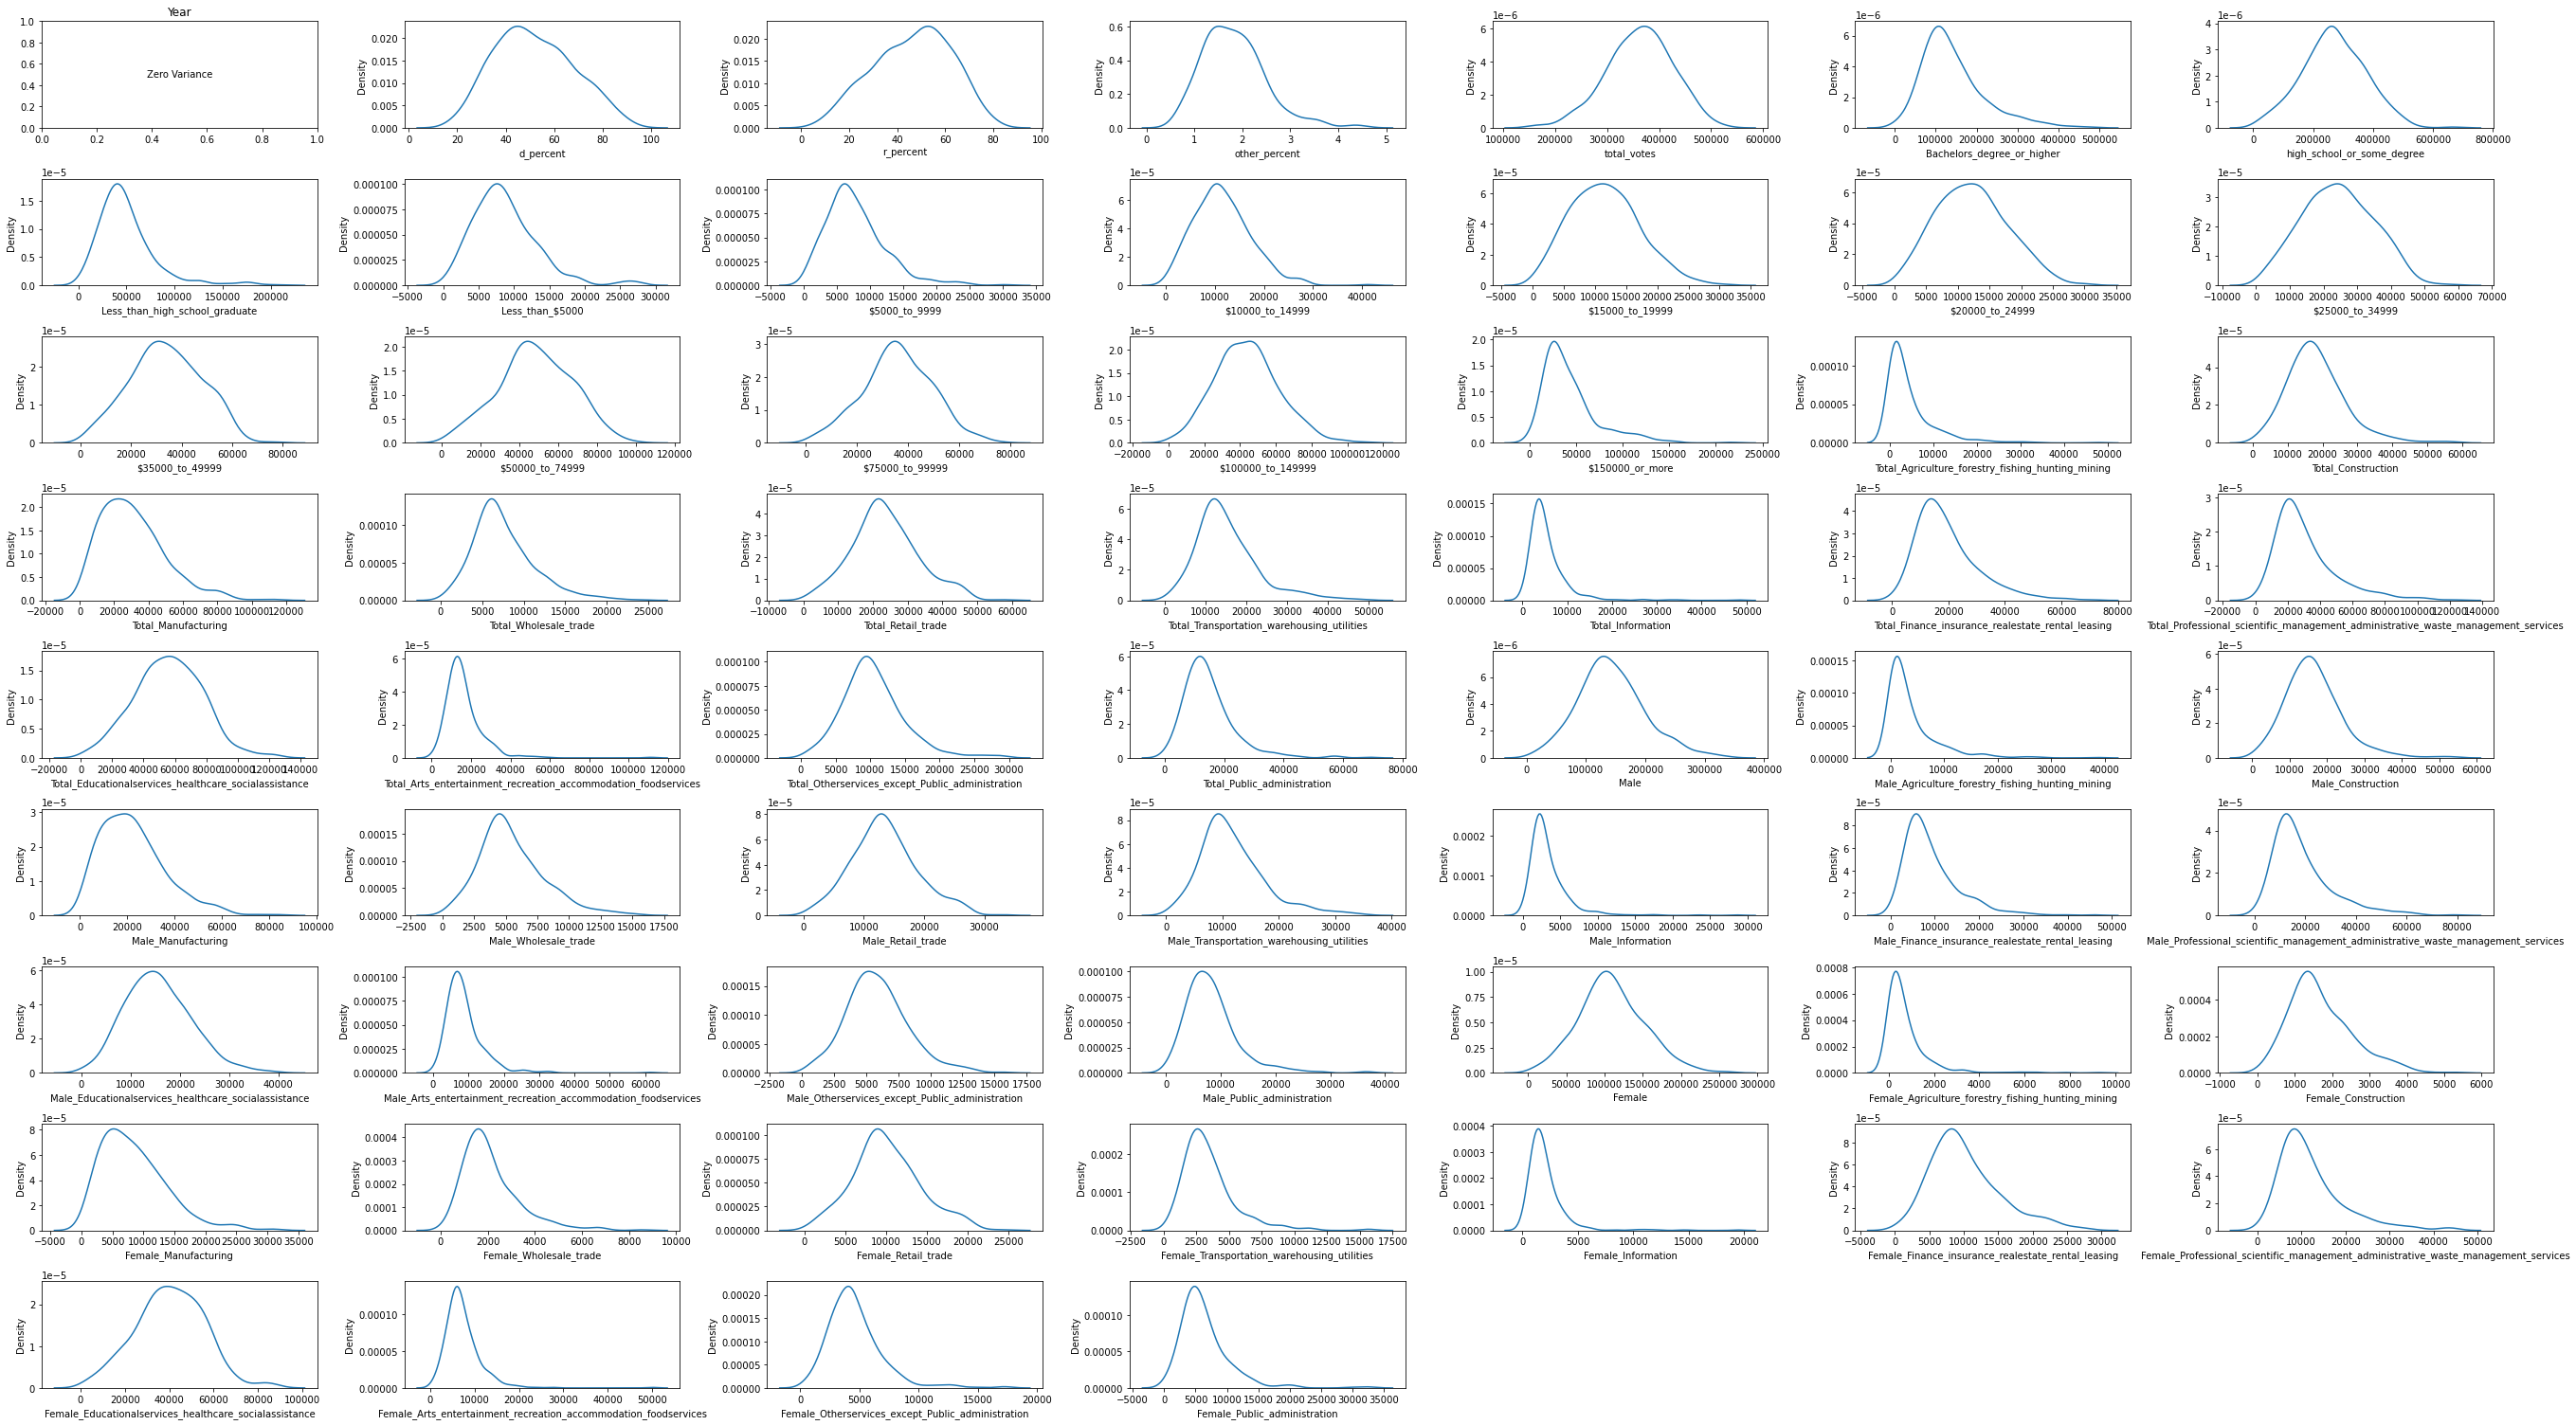

In [35]:
#grab all numeric type columns
numeric_columns = political_df.select_dtypes(include=['float64', 'int64']).columns.tolist()

#calculate the number of rows and columns needed
num_plots = len(numeric_columns)
num_cols = 7
num_rows = math.ceil(num_plots / num_cols)

#set a plot and multiple axes
fig, ax = plt.subplots(num_rows,num_cols,figsize=(37,21))
ax = ax.flatten()

#iterate over the numeric columns and plot distribution curves
for i, j in enumerate(numeric_columns):
    if political_df[j].var() != 0:  #check if the variance is not zero
        sns.kdeplot(political_df[j], ax=ax[i])
    else:
        ax[i].text(0.5, 0.5, 'Zero Variance', ha='center', va='center')
        ax[i].set_title(j)
    
#hide any unused subplots
for i in range(num_plots, len(ax)):
    fig.delaxes(ax[i])

#display results
plt.tight_layout()
plt.show()

#### Box-Cox
We proceeded to normalize the data using box-cox transformation, storing the transformed data into a separate dataframe. First, we looked at the results of applying the transformation to one column. Then we applied the transformation to all columns deemed skewed enough, storing the results in a separate dataframe.

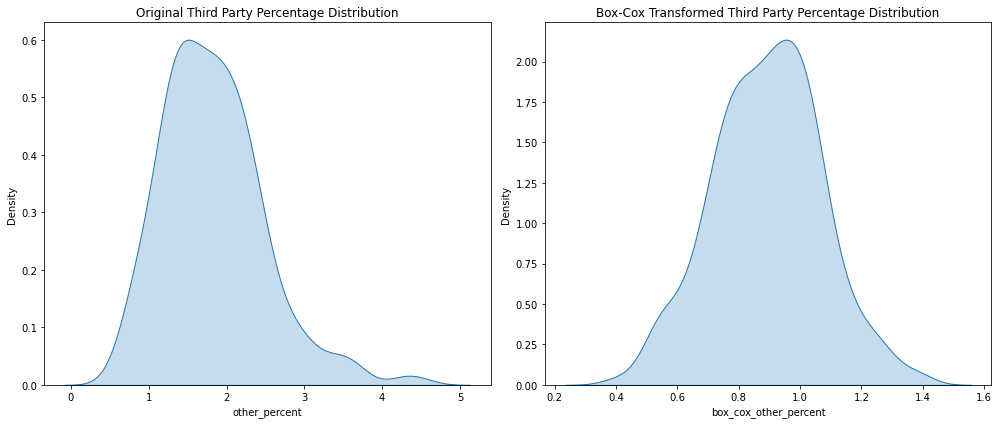

In [36]:
#copy the dataframe for normalization efforts
normal_df = political_df.copy(deep=True)

#add a constant to ensure all values are positive
normal_df['other_percent'] = normal_df['other_percent'] + 1 

#apply Box-Cox transformation
normal_df['box_cox_other_percent'], fitted_lambda = stats.boxcox(normal_df['other_percent'])

# Plot original and Box-Cox transformed data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.kdeplot(political_df['other_percent'], ax=axes[0], shade=True)
axes[0].set_title('Original Third Party Percentage Distribution')
sns.kdeplot(normal_df['box_cox_other_percent'], ax=axes[1], shade=True)
axes[1].set_title('Box-Cox Transformed Third Party Percentage Distribution')

plt.tight_layout()
plt.show()

In [37]:
#list of columns to apply Box-Cox transformation
columns_to_transform = [
    'Bachelors_degree_or_higher', 'Less_than_high_school_graduate', 'Less_than_$5000',
    '$5000_to_9999', '$150000_or_more', 'Total_Agriculture_forestry_fishing_hunting_mining',
    'Total_Manufacturing', 'Total_Wholesale_trade', 'Total_Transportation_warehousing_utilities',
    'Total_Information', 'Total_Finance_insurance_realestate_rental_leasing',
    'Total_Professional_scientific_management_administrative_waste_management_services',
    'Total_Arts_entertainment_recreation_accommodation_foodservices', 'Total_Public_administration',
    'Male_Agriculture_forestry_fishing_hunting_mining', 'Male_Manufacturing', 'Male_Wholesale_trade', 
    'Male_Transportation_warehousing_utilities', 'Male_Information', 
    'Male_Finance_insurance_realestate_rental_leasing',
    'Male_Professional_scientific_management_administrative_waste_management_services', 
    'Male_Arts_entertainment_recreation_accommodation_foodservices', 'Male_Public_administration',
    'Female_Agriculture_forestry_fishing_hunting_mining', 'Female_Manufacturing', 'Female_Wholesale_trade',
    'Female_Transportation_warehousing_utilities', 'Female_Information',
    'Female_Professional_scientific_management_administrative_waste_management_services',
    'Female_Arts_entertainment_recreation_accommodation_foodservices',
    'Female_Otherservices_except_Public_administration', 'Female_Public_administration'
]

#apply Box-Cox transformation to each specified column
for col in columns_to_transform:
    #apply Box-Cox transformation
    normal_df[f'box_cox_{col}'], fitted_lambda = stats.boxcox(normal_df[col] + 1)  #adding 1 to handle zero values
    #store the fitted_lambda value to check later
    print(f'Lambda for {col}: {fitted_lambda}')
    #remove the original column
    normal_df.drop(columns=[col], inplace=True)

#display the transformed DataFrame
print(normal_df)

Lambda for Bachelors_degree_or_higher: 0.36830686484531666
Lambda for Less_than_high_school_graduate: 0.25017371870565136
Lambda for Less_than_$5000: 0.41220776163471307
Lambda for $5000_to_9999: 0.40813386179843325
Lambda for $150000_or_more: 0.22030775458890195
Lambda for Total_Agriculture_forestry_fishing_hunting_mining: 0.08861204489562331
Lambda for Total_Manufacturing: 0.3785746409802615
Lambda for Total_Wholesale_trade: 0.3982299039662276
Lambda for Total_Transportation_warehousing_utilities: 0.3411038178430811
Lambda for Total_Information: 0.12057999838678898
Lambda for Total_Finance_insurance_realestate_rental_leasing: 0.2873992812919756
Lambda for Total_Professional_scientific_management_administrative_waste_management_services: 0.1428869866886102
Lambda for Total_Arts_entertainment_recreation_accommodation_foodservices: 0.18722299729922012
Lambda for Total_Public_administration: 0.3512767410139438
Lambda for Male_Agriculture_forestry_fishing_hunting_mining: 0.092637568483562

### Visual Data Analysis
In this section, we plotted graphs and displayed visual analysis of our findings regarding the location of swing districts and trends that can be useful in assessing the reason for certain election results around the country.  

#### Election Results by Year

This graph displays each party's percentage of the total vote by election year.

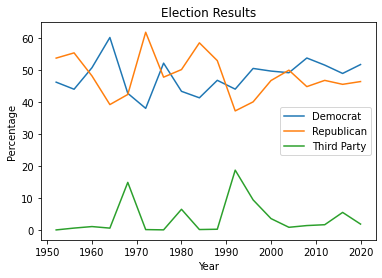

In [38]:
#group the election dataframe results by Year
grouped_df = election_df.groupby('Year').mean().reset_index()

#plot a line graph for each party's results by election year
plt.plot(grouped_df['Year'], grouped_df['d_percent'], label='Democrat')
plt.plot(grouped_df['Year'], grouped_df['r_percent'], label='Republican')
plt.plot(grouped_df['Year'], grouped_df['other_percent'], label='Third Party')

#set labels and titles
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Election Results')
plt.legend()

#display graph
plt.show()

#### Election Results by Year and State
This plot displays the parties' percentage of the total vote through the election years, separated by state. 

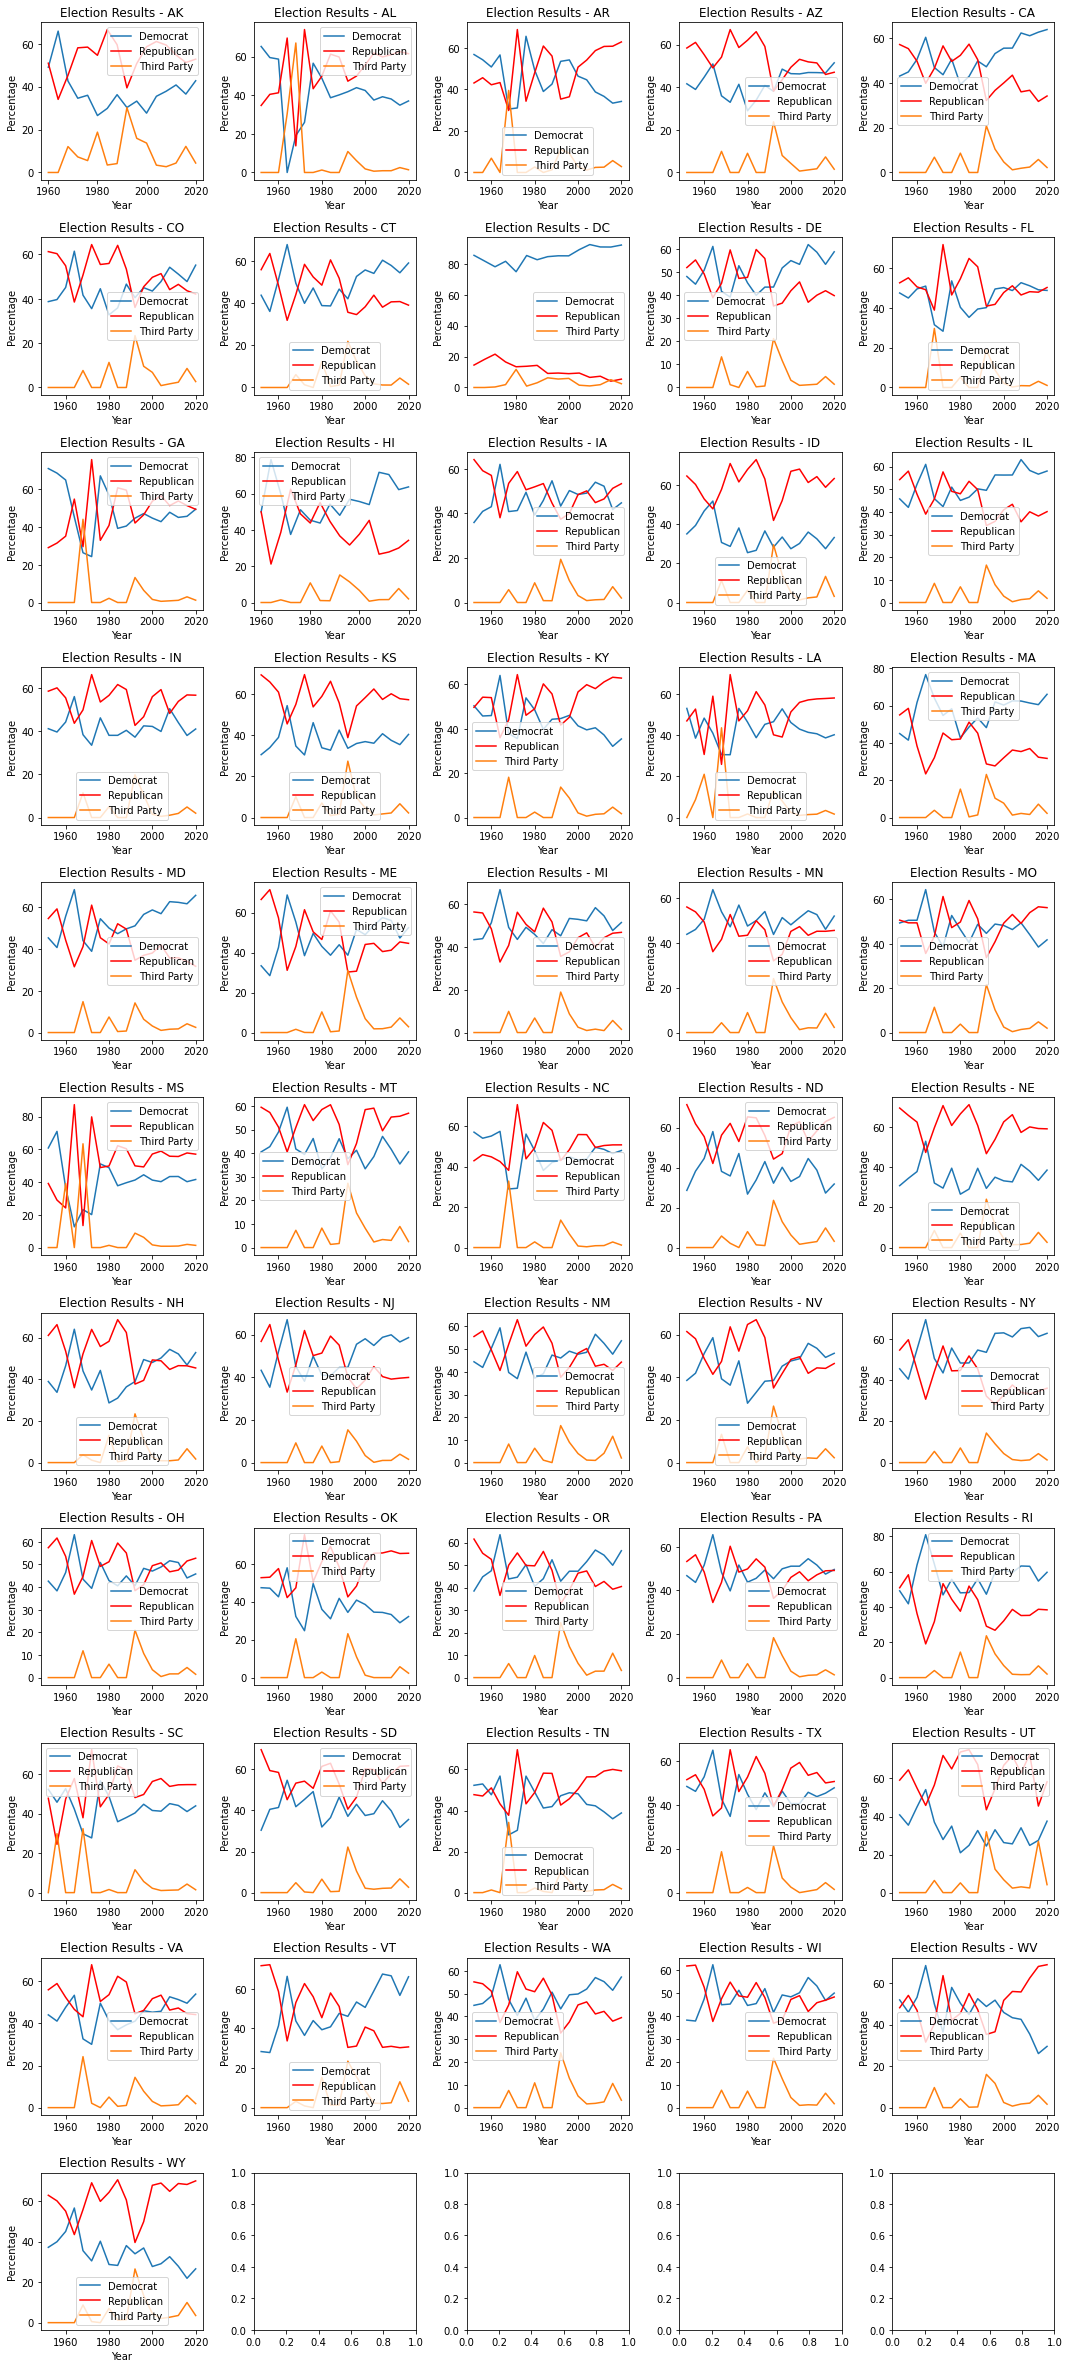

In [39]:
#create a 'state' column in election_df
election_df['state'] = election_df['district'].apply(lambda x: x[:2])

#group by 'state' and 'Year' columns and calculate the mean
grouped_df = election_df.groupby(['state', 'Year']).mean().reset_index()

#get a list of states
states = grouped_df['state'].unique()
num_states = len(states)

#calculate the number of rows and columns for the subplot grid
num_cols = 5
num_rows = (num_states + num_cols - 1) // num_cols

#create a grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3 * num_rows))

#iterate over states and plot on each subplot
for i, state in enumerate(states):
    state_df = grouped_df[grouped_df['state'] == state]

    row = i // num_cols
    col = i % num_cols

    axes[row, col].plot(state_df['Year'], state_df['d_percent'], label='Democrat')
    axes[row, col].plot(state_df['Year'], state_df['r_percent'], label='Republican', color='red')
    axes[row, col].plot(state_df['Year'], state_df['other_percent'], label='Third Party')

    axes[row, col].set_xlabel('Year')
    axes[row, col].set_ylabel('Percentage')
    axes[row, col].set_title(f'Election Results - {state}')
    axes[row, col].legend()

#display results
plt.tight_layout()
plt.show()

#### Target Column
We created the 'winner' column to be used for further viusal analysis and as our target for modeling, then we plotted a bar graph to visualize the number of district wins by party over the years.

In [40]:
#set the 'winner' column in political_df
for index, row in political_df.iterrows():
    if row['d_percent'] > row['r_percent']:
        political_df.at[index, 'winner'] = 'democrat'
    elif row['r_percent'] > row['d_percent']:
        political_df.at[index, 'winner'] = 'republican'
    else:
        political_df.at[index, 'winner'] = 'neither'
        
#view sample rows 
political_df.head(10)

,Year,district,d_percent,r_percent,other_percent,total_votes,Bachelors_degree_or_higher,high_school_or_some_degree,Less_than_high_school_graduate,Less_than_$5000,...,Female_Retail_trade,Female_Transportation_warehousing_utilities,Female_Information,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration,winner
0,2020,AK-00,42.77,52.83,4.40,359530.0,121098,309698,33572,5949,...,8599,5645,1726,5924,7889,35809,6225,3715,14619,republican
1,2020,AL-01,35.19,63.53,1.28,332777.0,96025,250831,44764,10004,...,10653,2347,889,7997,8812,36343,7015,4551,5038,republican
2,2020,AL-02,34.62,64.16,1.22,307431.0,109032,333132,69141,14763,...,11714,4145,1384,8717,8803,43616,7720,4445,12631,republican
3,2020,AL-03,34.08,64.67,1.25,325631.0,77833,267634,49575,13068,...,8521,2270,1026,7766,5546,34563,4949,3362,4704,republican
4,2020,AL-04,17.87,80.96,1.17,321470.0,69353,295273,67001,9793,...,11044,2952,981,5745,5551,36535,5555,3076,4866,republican
5,2020,AL-05,35.63,62.47,1.90,365610.0,118293,199894,36396,6636,...,7721,1969,1678,4729,11305,27309,4624,2593,7612,republican
6,2020,AL-06,31.42,66.69,1.89,372834.0,200747,369353,60132,14144,...,13288,5694,3285,19878,14576,59392,8865,6104,8078,republican
7,2020,AL-07,70.55,28.31,1.14,298712.0,55728,198658,32083,9456,...,5735,1700,561,4647,3102,27145,3563,2410,3648,democrat
8,2020,AR-01,27.93,69.06,3.01,271712.0,95999,398584,69560,14442,...,14189,4600,1380,9503,6984,54978,6705,4354,9332,republican
9,2020,AR-02,44.26,53.11,2.63,333347.0,105763,196882,23807,8516,...,7767,2486,2142,7453,7980,37493,4898,3284,5988,republican


In [41]:
#view sample rows where 'democrat' is the winner
political_df[political_df['winner'] == 'democrat'].head(10)

,Year,district,d_percent,r_percent,other_percent,total_votes,Bachelors_degree_or_higher,high_school_or_some_degree,Less_than_high_school_graduate,Less_than_$5000,...,Female_Retail_trade,Female_Transportation_warehousing_utilities,Female_Information,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration,winner
7,2020,AL-07,70.55,28.31,1.14,298712.0,55728,198658,32083,9456,...,5735,1700,561,4647,3102,27145,3563,2410,3648,democrat
12,2020,AZ-01,50.11,48.36,1.53,373579.0,238202,283685,48500,11733,...,14425,4052,2650,22948,22405,45945,10077,6700,6209,democrat
13,2020,AZ-02,54.52,43.89,1.59,391436.0,120696,462767,92311,18896,...,14668,4050,1780,11346,10014,50818,11402,4597,12660,democrat
14,2020,AZ-03,62.79,35.74,1.47,278497.0,24685,110656,58520,4033,...,3771,2133,580,4166,5479,11815,4224,1871,2554,democrat
18,2020,AZ-07,73.66,24.73,1.61,224168.0,16291,67774,19086,2564,...,2081,952,237,1824,2513,7806,1167,808,2075,democrat
20,2020,AZ-09,60.79,37.34,1.87,368798.0,129242,488434,124233,14379,...,18438,6968,1952,19182,14797,55848,12609,6080,11174,democrat
22,2020,CA-02,73.52,23.88,2.60,400545.0,236979,353070,70389,10620,...,13644,3126,3871,11526,19205,44063,11364,8406,9004,democrat
23,2020,CA-03,54.89,42.64,2.47,327561.0,214017,397623,48507,10293,...,11899,4184,2039,17538,16665,49027,9963,6414,16351,democrat
25,2020,CA-05,72.43,25.26,2.31,364624.0,153229,487303,122054,10699,...,13603,4751,1924,10487,11715,56265,9546,5733,11272,democrat
26,2020,CA-06,70.24,27.22,2.54,320643.0,96816,236822,40311,6502,...,8734,3735,1125,8701,9988,27354,5318,3417,11571,democrat


In [42]:
#check there are only two 'winner' values
political_df['winner'].unique()

array(['republican', 'democrat'], dtype=object)

In [43]:
#set the 'winner' column in election_df
for index, row in election_df.iterrows():
    if row['d_percent'] > row['r_percent']:
        election_df.at[index, 'winner'] = 'democrat'
    elif row['r_percent'] > row['d_percent']:
        election_df.at[index, 'winner'] = 'republican'
    else:
        election_df.at[index, 'winner'] = 'neither'

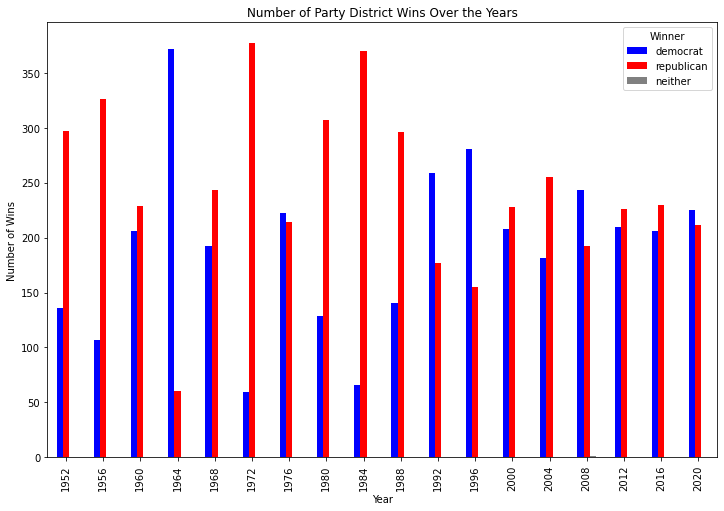

In [44]:
#group by 'Year' and 'winner', then count the occurrences
winner_count_df = election_df.groupby(['Year', 'winner']).size().unstack(fill_value=0)

#define the colors of the bars
colors = ['blue', 'red', 'grey']

#define a color mapping for each category
color_mapping = {'democrat': 'blue', 'republican': 'red', 'neither': 'grey'}


#ensure the columns are in order
columns_order = ['democrat', 'republican', 'neither']
colors = [color_mapping[col] for col in columns_order]

#plotting the aggregated data with custom colors
winner_count_df = winner_count_df[columns_order]
winner_count_df.plot(kind='bar', figsize=(12, 8), color=colors)

#set labels
plt.title('Number of Party District Wins Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend(title='Winner')

#display results
plt.show()

#### Swing District

We created a column that determines whether a district is a swing district based on if the results were within 9 points between parties. This is applied to both our election and fully merged datasets and will be used for deeper analysis.

In [45]:
#create 'swing_district' column in election_df
for index, row in election_df.iterrows():
    if abs(row['d_percent'] - row['r_percent']) <= 9:
        election_df.at[index, 'swing_district'] = 'yes'
    else:
        election_df.at[index, 'swing_district'] = 'no'

#view sample rows
election_df.head(20)

,Year,district,d_percent,r_percent,other_percent,total_votes,state,winner,swing_district
0,1952,AL-01,57.76,42.24,0.0,45915.0,AL,democrat,no
1,1952,AL-02,63.19,36.81,0.0,48972.0,AL,democrat,no
2,1952,AL-03,72.23,27.77,0.0,36062.0,AL,democrat,no
3,1952,AL-04,64.14,35.86,0.0,41456.0,AL,democrat,no
4,1952,AL-05,72.69,27.31,0.0,55867.0,AL,democrat,no
5,1952,AL-06,61.27,38.73,0.0,31041.0,AL,democrat,no
6,1952,AL-07,62.58,37.42,0.0,46803.0,AL,democrat,no
7,1952,AL-08,79.55,20.45,0.0,48313.0,AL,democrat,no
8,1952,AL-09,54.16,45.84,0.0,70365.0,AL,democrat,yes
9,1952,AR-01,60.83,39.17,0.0,60089.0,AR,democrat,no


In [46]:
#view total swing and non-swing districts
print('Total Swing Districts: ', (election_df['swing_district'] == 'yes').sum())
print('Total Non-Swing Districts: ', (election_df['swing_district'] == 'no').sum())

Total Swing Districts:  1969
Total Non-Swing Districts:  5867


In [47]:
#view total swing and non-swing districts post 2000
print('Total Swing Districts post 2000: ', (election_df[(election_df['swing_district'] == 'yes') & (election_df['Year'] >= 2000)].shape[0]))
print('Total Non-Swing Districts post 2000: ', (election_df[(election_df['swing_district'] == 'no') & (election_df['Year'] >= 2000)].shape[0]))

Total Swing Districts post 2000:  553
Total Non-Swing Districts post 2000:  2063


In [48]:
#create 'swing_district' column in political_df
for index, row in political_df.iterrows():
    if abs(row['d_percent'] - row['r_percent']) <= 9:
        political_df.at[index, 'swing_district'] = 'yes'
    else:
        political_df.at[index, 'swing_district'] = 'no'

#view sample rows
political_df.head(20)

,Year,district,d_percent,r_percent,other_percent,total_votes,Bachelors_degree_or_higher,high_school_or_some_degree,Less_than_high_school_graduate,Less_than_$5000,...,Female_Transportation_warehousing_utilities,Female_Information,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration,winner,swing_district
0,2020,AK-00,42.77,52.83,4.40,359530.0,121098,309698,33572,5949,...,5645,1726,5924,7889,35809,6225,3715,14619,republican,no
1,2020,AL-01,35.19,63.53,1.28,332777.0,96025,250831,44764,10004,...,2347,889,7997,8812,36343,7015,4551,5038,republican,no
2,2020,AL-02,34.62,64.16,1.22,307431.0,109032,333132,69141,14763,...,4145,1384,8717,8803,43616,7720,4445,12631,republican,no
3,2020,AL-03,34.08,64.67,1.25,325631.0,77833,267634,49575,13068,...,2270,1026,7766,5546,34563,4949,3362,4704,republican,no
4,2020,AL-04,17.87,80.96,1.17,321470.0,69353,295273,67001,9793,...,2952,981,5745,5551,36535,5555,3076,4866,republican,no
5,2020,AL-05,35.63,62.47,1.90,365610.0,118293,199894,36396,6636,...,1969,1678,4729,11305,27309,4624,2593,7612,republican,no
6,2020,AL-06,31.42,66.69,1.89,372834.0,200747,369353,60132,14144,...,5694,3285,19878,14576,59392,8865,6104,8078,republican,no
7,2020,AL-07,70.55,28.31,1.14,298712.0,55728,198658,32083,9456,...,1700,561,4647,3102,27145,3563,2410,3648,democrat,no
8,2020,AR-01,27.93,69.06,3.01,271712.0,95999,398584,69560,14442,...,4600,1380,9503,6984,54978,6705,4354,9332,republican,no
9,2020,AR-02,44.26,53.11,2.63,333347.0,105763,196882,23807,8516,...,2486,2142,7453,7980,37493,4898,3284,5988,republican,yes


In [49]:
#view total swing and non-swing districts in 2020
print('Total Swing Districts in 2020: ', (political_df[political_df['swing_district'] == 'yes'].shape[0]))
print('Total Non-Swing Districts in 2020: ', (political_df[political_df['swing_district'] == 'no'].shape[0]))

Total Swing Districts in 2020:  81
Total Non-Swing Districts in 2020:  347


In [50]:
#create dataframe of of swing districts in 1952 and in 2020
swing_districts_1952 = election_df[(election_df['Year'] == 1952) & (election_df['swing_district'] == 'yes')]
swing_districts_2020 = election_df[(election_df['Year'] == 2020) & (election_df['swing_district'] == 'yes')]

#merge the swing districts that are present in both elections
swing_districts_both_years = swing_districts_1952.merge(swing_districts_2020, on='district')

#display results
swing_districts_both_years

,Year_x,district,d_percent_x,r_percent_x,other_percent_x,total_votes_x,state_x,winner_x,swing_district_x,Year_y,d_percent_y,r_percent_y,other_percent_y,total_votes_y,state_y,winner_y,swing_district_y
0,1952,NC-08,51.09,48.91,0.0,116991.0,NC,democrat,yes,2020,45.60,53.04,1.36,390839.0,NC,republican,yes
1,1952,NJ-11,46.88,53.12,0.0,131462.0,NJ,republican,yes,2020,52.46,45.86,1.68,453555.0,NJ,democrat,yes
2,1952,TX-03,49.26,50.74,0.0,74135.0,TX,republican,yes,2020,48.58,49.62,1.80,432029.0,TX,republican,yes
3,1952,TX-07,54.47,45.53,0.0,57385.0,TX,democrat,yes,2020,53.55,45.09,1.36,317565.0,TX,democrat,yes
4,1952,TX-10,50.76,49.24,0.0,77787.0,TX,democrat,yes,2020,48.35,49.98,1.67,421768.0,TX,republican,yes
5,1952,VA-01,47.78,52.22,0.0,52692.0,VA,republican,yes,2020,46.87,51.27,1.86,454745.0,VA,republican,yes
6,1952,VA-02,52.05,47.95,0.0,51097.0,VA,democrat,yes,2020,51.14,46.68,2.18,361515.0,VA,democrat,yes
7,1952,VA-05,46.36,53.64,0.0,55216.0,VA,republican,yes,2020,44.97,53.41,1.62,407348.0,VA,republican,yes
8,1952,WA-03,46.22,53.78,0.0,147363.0,WA,republican,yes,2020,46.56,50.30,3.14,426189.0,WA,republican,yes


#### Swing Districts Graphs 
The following graph displays the election history of districts that have had swing-level margins in both 1952 and present day. The next graph displays the number of said swing district wins by party over the years.

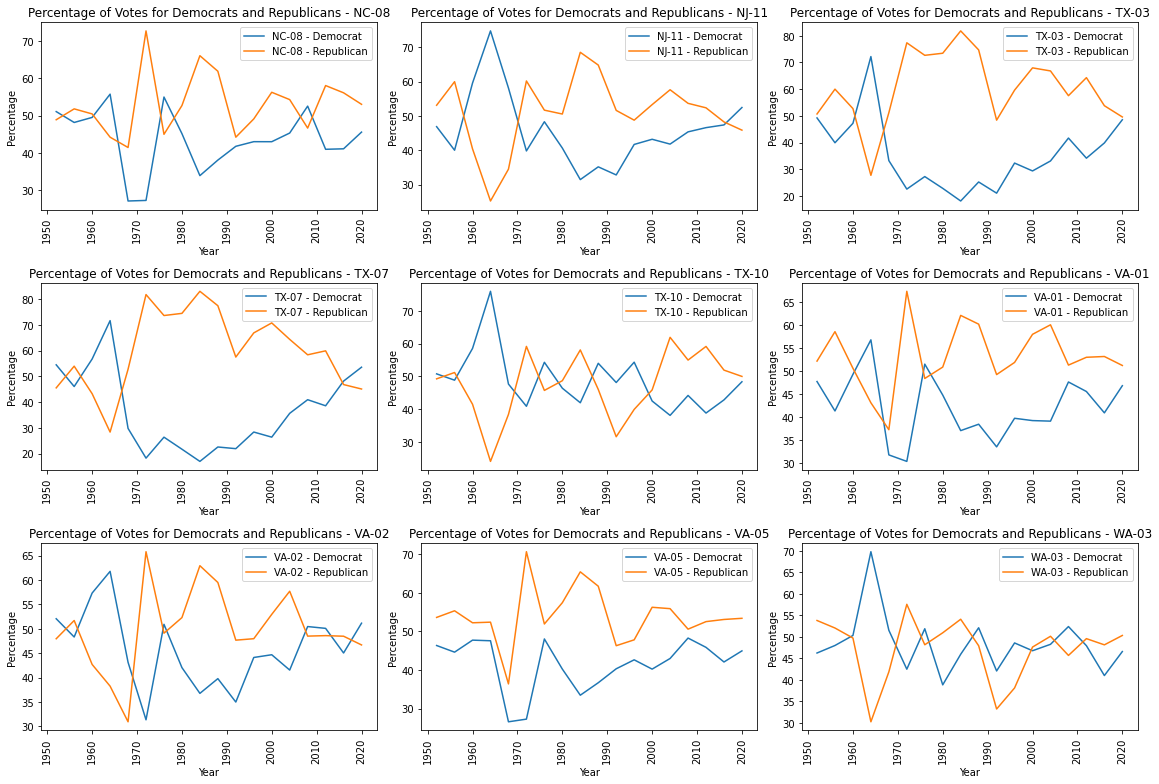

In [51]:
#filter the original election_df DataFrame for the districts in_districts_both_years
districts = swing_districts_both_years['district'].unique()

#calculate the number of rows and columns for the subplot grid
num_districts = len(districts)
num_cols = math.ceil(math.sqrt(num_districts))
num_rows = math.ceil(num_districts / num_cols)

#create subplots for each district
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 11))

#flatten the axs array if necessary
if num_districts == 1:
    axs = [axs]

#plot a separate graph for each district
for i, district in enumerate(districts):
    district_data = election_df[election_df['district'] == district]
    ax = axs[i // num_cols, i % num_cols]
    ax.plot(district_data['Year'], district_data['d_percent'], label=f'{district} - Democrat')
    ax.plot(district_data['Year'], district_data['r_percent'], label=f'{district} - Republican')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Percentage of Votes for Democrats and Republicans - {district}')
    ax.legend()
    ax.tick_params(axis='x', rotation=90)

#remove empty subplots if necessary
if num_districts < num_rows * num_cols:
    for i in range(num_districts, num_rows * num_cols):
        fig.delaxes(axs[i // num_cols, i % num_cols])

#display results 
plt.tight_layout()
plt.show()

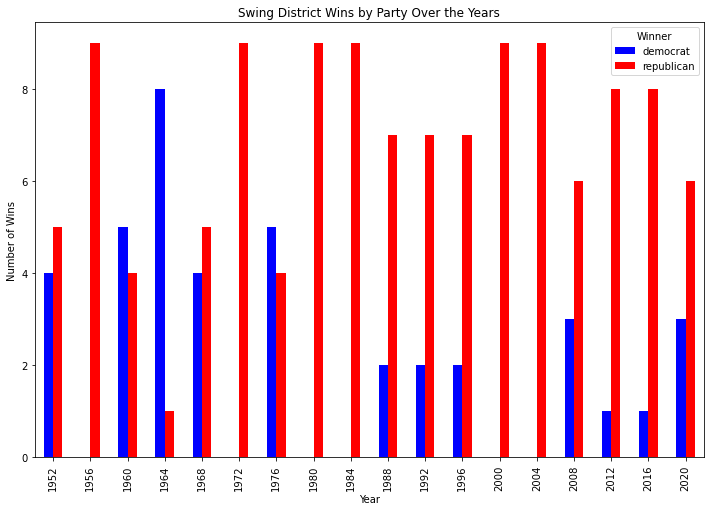

In [52]:
#filter out the swing districts
swing_election_df = election_df[election_df['district'].isin(districts)]

#group by 'Year' and 'winner', then count the occurrences
winner_count_swing = swing_election_df.groupby(['Year', 'winner']).size().unstack(fill_value=0)

#ensure the columns are in order
columns_order = ['democrat', 'republican']
colors = [color_mapping[col] for col in columns_order]

#plotting the aggregated data with custom colors
winner_count_swing = winner_count_swing[columns_order]
winner_count_swing.plot(kind='bar', figsize=(12, 8), color=colors)

#set labels
plt.title('Swing District Wins by Party Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend(title='Winner')
plt.show()

#### Total Votes by Party
Here, we add a column that displays each party's total votes in election_df and political_df.

In [53]:
#create 'total_votes' columns by party and display sample rows in election_df
election_df['r_total_votes'] = election_df['r_percent'] * .01 * election_df['total_votes']
election_df['r_total_votes'] = election_df['r_total_votes'].astype(int)
election_df['d_total_votes'] = election_df['d_percent'] * .01 * election_df['total_votes']
election_df['d_total_votes'] = election_df['d_total_votes'].astype(int)
election_df.head()

,Year,district,d_percent,r_percent,other_percent,total_votes,state,winner,swing_district,r_total_votes,d_total_votes
0,1952,AL-01,57.76,42.24,0.0,45915.0,AL,democrat,no,19394,26520
1,1952,AL-02,63.19,36.81,0.0,48972.0,AL,democrat,no,18026,30945
2,1952,AL-03,72.23,27.77,0.0,36062.0,AL,democrat,no,10014,26047
3,1952,AL-04,64.14,35.86,0.0,41456.0,AL,democrat,no,14866,26589
4,1952,AL-05,72.69,27.31,0.0,55867.0,AL,democrat,no,15257,40609


In [54]:
#create 'total_votes' columns by party and display sample rows in political_df
political_df['r_total_votes'] = political_df['r_percent'] * .01 * political_df['total_votes']
political_df['r_total_votes'] = political_df['r_total_votes'].astype(int)
political_df['d_total_votes'] = political_df['d_percent'] * .01 * political_df['total_votes']
political_df['d_total_votes'] = political_df['d_total_votes'].astype(int)
political_df.head()

,Year,district,d_percent,r_percent,other_percent,total_votes,Bachelors_degree_or_higher,high_school_or_some_degree,Less_than_high_school_graduate,Less_than_$5000,...,Female_Finance_insurance_realestate_rental_leasing,Female_Professional_scientific_management_administrative_waste_management_services,Female_Educationalservices_healthcare_socialassistance,Female_Arts_entertainment_recreation_accommodation_foodservices,Female_Otherservices_except_Public_administration,Female_Public_administration,winner,swing_district,r_total_votes,d_total_votes
0,2020,AK-00,42.77,52.83,4.40,359530.0,121098,309698,33572,5949,...,5924,7889,35809,6225,3715,14619,republican,no,189939,153770
1,2020,AL-01,35.19,63.53,1.28,332777.0,96025,250831,44764,10004,...,7997,8812,36343,7015,4551,5038,republican,no,211413,117104
2,2020,AL-02,34.62,64.16,1.22,307431.0,109032,333132,69141,14763,...,8717,8803,43616,7720,4445,12631,republican,no,197247,106432
3,2020,AL-03,34.08,64.67,1.25,325631.0,77833,267634,49575,13068,...,7766,5546,34563,4949,3362,4704,republican,no,210585,110975
4,2020,AL-04,17.87,80.96,1.17,321470.0,69353,295273,67001,9793,...,5745,5551,36535,5555,3076,4866,republican,no,260262,57446


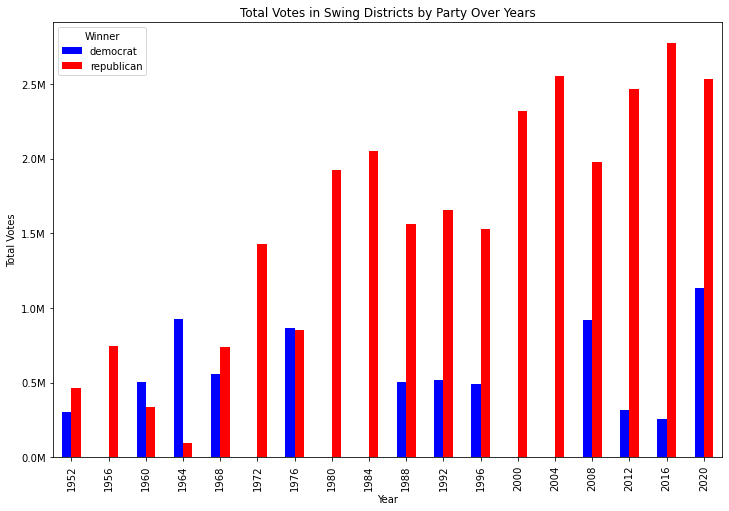

In [55]:
#group by 'Year' and 'winner', then sum the 'total_votes'
total_votes_swing = swing_election_df.groupby(['Year', 'winner'])['total_votes'].sum().unstack(fill_value=0)

#plotting the aggregated data with custom colors
total_votes_swing = total_votes_swing[columns_order]  # Reorder columns if necessary
ax = total_votes_swing.plot(kind='bar', figsize=(12, 8), color=colors)

#set labels
plt.title('Total Votes in Swing Districts by Party Over Years')
plt.xlabel('Year')
plt.ylabel('Total Votes')
plt.legend(title='Winner')

#format the x-axis labels to be more readable (e.g., using millions)
formatter = ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x / 1e6))
ax.yaxis.set_major_formatter(formatter)

#display results
plt.show()

### State Election Results

We created a dataframe grouping the election results by state for analysis, including examination of each state's share of the national vote.

In [56]:
#group election_df by state into new dataframe
state_election_df = election_df.groupby(['state', 'Year']).agg({
    'total_votes': 'sum',
    'd_percent': 'mean',
    'r_percent': 'mean',
    'r_total_votes': 'sum',
    'd_total_votes': 'sum'
}).reset_index()

In [57]:
#create 'national_percent' column in state_election_df
state_election_df['national_percent'] = state_election_df['total_votes'] / state_election_df.groupby('Year')['total_votes'].transform('sum')

In [58]:
#view sample rows in California
state_election_df[state_election_df['state'] == 'CA'].head(18)

,state,Year,total_votes,d_percent,r_percent,r_total_votes,d_total_votes,national_percent
70,CA,1952,5022476.0,42.978333,57.021667,2846212,2176234,0.076843
71,CA,1956,5378511.0,44.806667,55.193333,2977696,2400785,0.081644
72,CA,1960,5622012.0,50.409333,49.590667,2800272,2821711,0.082788
73,CA,1964,7027389.0,60.254211,39.745789,2840172,4187181,0.101577
74,CA,1968,7056629.0,46.778684,46.407632,3379759,3195513,0.097731
75,CA,1972,8056796.0,43.571395,56.428605,4590299,3466454,0.105934
76,CA,1976,7591811.0,50.485581,49.514419,3861052,3730716,0.095371
77,CA,1980,8346967.0,39.174186,52.207907,4523470,3083172,0.098084
78,CA,1984,9389472.0,42.800000,57.200000,5466956,3922471,0.101948
79,CA,1988,9757150.0,49.707556,50.292444,5054920,4702185,0.107330


In [59]:
#display modern day swing states
print("Modern Day Swing States: ")
swing_states = []

#filter the dataframe for years starting from 2000 onwards
state_filtered_df = state_election_df[state_election_df['Year'] >= 2000]

#group the filtered dataframe by 'state' and check the conditions for swing states
for state, group in state_filtered_df.groupby('state'):
    if any(group['d_total_votes'] > group['r_total_votes']) and any(group['d_total_votes'] < group['r_total_votes']):
        swing_states.append(state)
for state in swing_states:
    print(state)
print("Number of Swing States:",len(swing_states))

Modern Day Swing States: 
AZ
CO
FL
GA
IA
IN
MI
NC
NH
NM
NV
OH
PA
VA
WI
Number of Swing States: 15


### Swing States Election Results
This graph displays the election results by party for each swing state over the years.

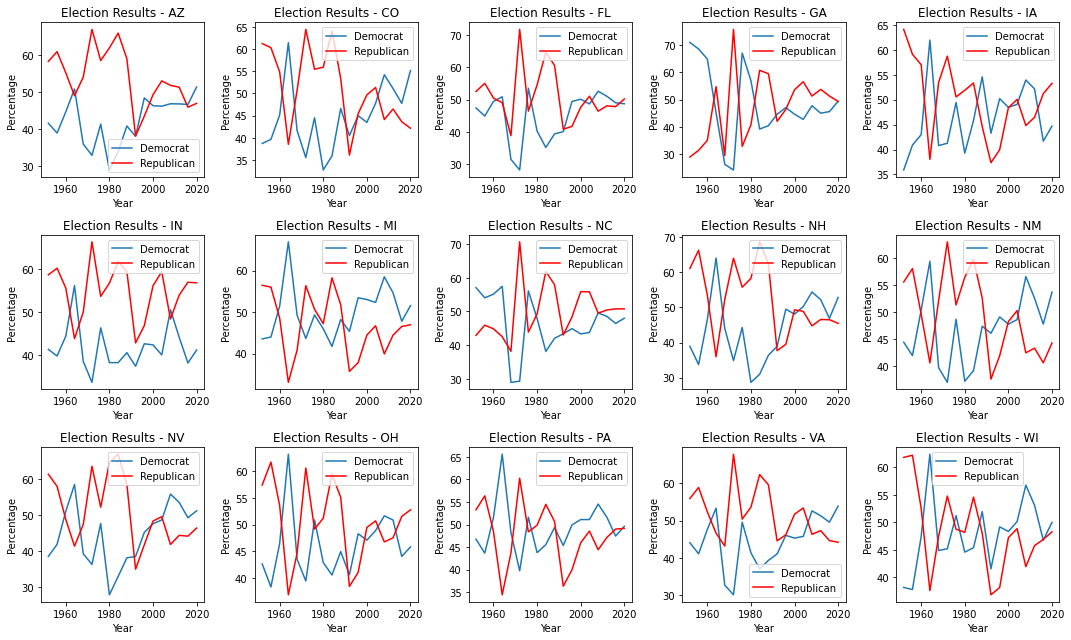

In [60]:
#get number of swing states
num_states = len(swing_states)

#calculate the number of rows and columns for the subplot grid
num_cols = 5
num_rows = (num_states + num_cols - 1) // num_cols

#create a grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3 * num_rows))

#iterate over states and plot on each subplot
for i, state in enumerate(swing_states):
    state_df = state_election_df[state_election_df['state'] == state]

    row = i // num_cols
    col = i % num_cols

    axes[row, col].plot(state_df['Year'], state_df['d_percent'], label='Democrat')
    axes[row, col].plot(state_df['Year'], state_df['r_percent'], label='Republican', color='red')
    #axes[row, col].plot(state_election_df['Year'], state_election_df['other_percent'], label='Third Party')

    axes[row, col].set_xlabel('Year')
    axes[row, col].set_ylabel('Percentage')
    axes[row, col].set_title(f'Election Results - {state}')
    axes[row, col].legend()

#display results
plt.tight_layout()
plt.show()

#### Swing State Winner 
We then filtered the data to group by swing states and visualized the winning party over the years in terms of total number of swing state wins, total votes across the swing states, and the winning party of each swing state.

In [61]:
#filter dataframe to just include swing states
swing_state_df = state_election_df.loc[state_election_df['state'].isin(swing_states)].copy()

#set the 'winner' column in swing_state_df
for index, row in swing_state_df.iterrows():
    if row['d_total_votes'] > row['r_total_votes']:
        swing_state_df.at[index, 'winner'] = 'democrat'
    elif row['r_total_votes'] > row['d_total_votes']:
        swing_state_df.at[index, 'winner'] = 'republican'
    else:
        swing_state_df.at[index, 'winner'] = 'neither'
        
#view sample rows 
swing_state_df.head(10)

,state,Year,total_votes,d_percent,r_percent,r_total_votes,d_total_votes,national_percent,winner
52,AZ,1952,260570.0,41.605000,58.395000,152039,108529,0.003987,republican
53,AZ,1956,289870.0,38.960000,61.040000,176984,112884,0.004400,republican
54,AZ,1960,398022.0,44.725000,55.275000,221239,176781,0.005861,republican
55,AZ,1964,451549.5,50.926667,49.073333,223180,228366,0.006527,democrat
56,AZ,1968,481177.0,35.960000,54.146667,264814,170017,0.006664,republican
57,AZ,1972,601352.0,32.935000,67.065000,402803,198545,0.007907,republican
58,AZ,1976,712980.0,41.377500,58.622500,418071,294905,0.008957,republican
59,AZ,1980,851844.0,28.947500,62.047500,529079,246415,0.010010,republican
60,AZ,1984,1015270.0,33.934000,66.066000,681432,333833,0.011024,republican
61,AZ,1988,1156570.0,40.870000,59.130000,702550,454015,0.012722,republican


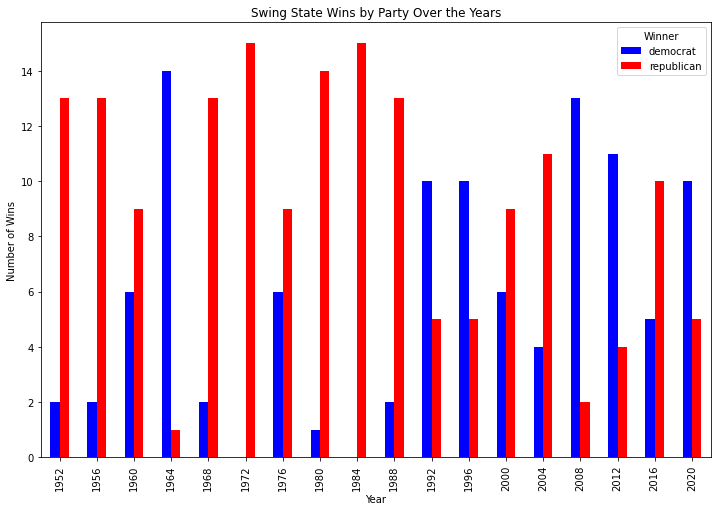

In [62]:
#group by 'Year' and 'winner', then count the occurrences
winner_swing_state = swing_state_df.groupby(['Year', 'winner']).size().unstack(fill_value=0)

#ensure the columns are in order
columns_order = ['democrat', 'republican']
colors = [color_mapping[col] for col in columns_order]

#plotting the aggregated data with custom colors
winner_swing_state = winner_swing_state[columns_order]
winner_swing_state.plot(kind='bar', figsize=(12, 8), color=colors)

#set labels
plt.title('Swing State Wins by Party Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Wins')
plt.legend(title='Winner')
plt.show()

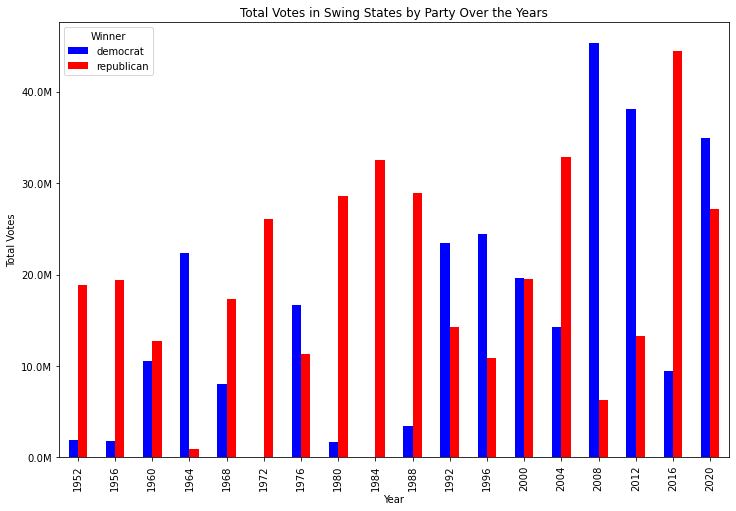

In [63]:
#group by 'Year' and 'winner', then sum the 'total_votes'
total_votes_state = swing_state_df.groupby(['Year', 'winner'])['total_votes'].sum().unstack(fill_value=0)

#plotting the aggregated data with custom colors
total_votes_state = total_votes_state[columns_order]  # Reorder columns if necessary
ax = total_votes_state.plot(kind='bar', figsize=(12, 8), color=colors)

#set labels
plt.title('Total Votes in Swing States by Party Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Votes')
plt.legend(title='Winner')

#format the x-axis labels to be more readable (e.g., using millions)
formatter = ticker.FuncFormatter(lambda x, pos: '{:.1f}M'.format(x / 1e6))
ax.yaxis.set_major_formatter(formatter)

#display results
plt.show()

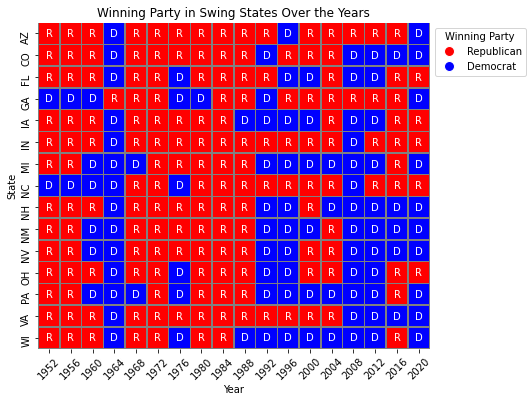

In [64]:
#encode winner column
party_mapping = {'republican': 1, 'democrat': 0}
swing_state_df['winner_encoded'] = swing_state_df['winner'].map(party_mapping)

#pivoting the DataFrame for heatmap
pivot_df = swing_state_df.pivot(index='state', columns='Year', values='winner_encoded')

#fill NaN values with a placeholder
pivot_df = pivot_df.fillna(np.nan)

#custom colormap
cmap = sns.color_palette(["#0000FF", "#FF0000"], as_cmap=True)  

#heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(pivot_df, cmap=cmap, cbar=False, linewidths=.5, linecolor='grey', square=True, annot=False)

#adding text annotations for 'Republican' and 'Democrat'
for i in range(len(pivot_df.index)):
    for j in range(len(pivot_df.columns)):
        value = pivot_df.iloc[i, j]
        if not np.isnan(value):
            text = 'R' if value == 1 else 'D'
            ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='white')

#adding a custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Republican', markersize=10, markerfacecolor='#FF0000'),
                   Line2D([0], [0], marker='o', color='w', label='Democrat', markersize=10, markerfacecolor='#0000FF')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1,1), title='Winning Party')

#set labels
plt.title('Winning Party in Swing States Over the Years')
plt.ylabel('State')
plt.xlabel('Year')
plt.xticks(rotation=45)

#display results
plt.show()

In [65]:
#create dataframe of election data post 2000
modern_election_df = election_df[election_df['Year'] >= 2000]
modern_election_df.head()

,Year,district,d_percent,r_percent,other_percent,total_votes,state,winner,swing_district,r_total_votes,d_total_votes
5222,2000,AK-00,27.67,58.62,13.71,285560.0,AK,republican,no,167395,79014
5223,2000,AL-01,37.75,60.17,2.08,233974.0,AL,republican,no,140782,88325
5224,2000,AL-02,35.53,62.92,1.55,231428.0,AL,republican,no,145614,82226
5225,2000,AL-03,41.30,56.79,1.91,222458.0,AL,republican,no,126333,91875
5226,2000,AL-04,38.90,59.25,1.85,232673.0,AL,republican,no,137858,90509


#### Swing State Districts
Next, we graphed each swing state's districts, indicating their percentage of the state vote, the winning party in 2020, and whether or not they qualify as a swing district.

In [66]:
#make a copy
state_filtered_df = state_filtered_df.copy()

#create 'swing_district' column in election_df
state_filtered_df.loc[state_filtered_df['state'].isin(swing_states), 'swing_state'] = 'yes'

#view sample rows
state_filtered_df.head(20)

,state,Year,total_votes,d_percent,r_percent,r_total_votes,d_total_votes,national_percent,swing_state
10,AK,2000,285560.0,27.670000,58.620000,167395,79014,0.002713,NaN
11,AK,2004,312598.0,35.520000,61.070000,190903,111034,0.002561,NaN
12,AK,2008,326197.0,37.890000,59.420000,193826,123596,0.002485,NaN
13,AK,2012,300495.0,40.810000,54.800000,164671,122632,0.002331,NaN
14,AK,2016,318608.0,36.550000,51.280000,163382,116451,0.002336,NaN
15,AK,2020,359530.0,42.770000,52.830000,189939,153770,0.002270,NaN
28,AL,2000,1665242.0,42.474286,55.674286,941159,692638,0.015820,NaN
29,AL,2004,1881835.0,37.504286,61.837143,1175533,693812,0.015415,NaN
30,AL,2008,2098939.0,39.240000,59.857143,1266505,813452,0.015992,NaN
31,AL,2012,2070184.0,38.072857,61.018571,1255881,795596,0.016056,NaN


In [67]:
#print whether each district is a swing district for every swing state
for state in swing_states:
    print('\n')
    print(f"{state} districts: ")
    for index, row in modern_election_df.iterrows():
        if row['Year'] == 2020 and row['state'] == state:
            print(f"{row['district']}: {row['swing_district']} swing district")



AZ districts: 
AZ-01: yes swing district
AZ-02: no swing district
AZ-03: no swing district
AZ-04: no swing district
AZ-05: no swing district
AZ-06: yes swing district
AZ-07: no swing district
AZ-08: no swing district
AZ-09: no swing district


CO districts: 
CO-01: no swing district
CO-02: no swing district
CO-03: yes swing district
CO-04: no swing district
CO-05: no swing district
CO-06: no swing district
CO-07: no swing district


FL districts: 
FL-01: no swing district
FL-02: no swing district
FL-03: no swing district
FL-04: no swing district
FL-05: no swing district
FL-06: no swing district
FL-07: no swing district
FL-08: no swing district
FL-09: yes swing district
FL-10: no swing district
FL-11: no swing district
FL-12: no swing district
FL-13: yes swing district
FL-14: no swing district
FL-15: yes swing district
FL-16: yes swing district
FL-17: no swing district
FL-18: yes swing district
FL-19: no swing district
FL-20: no swing district
FL-21: no swing district
FL-22: no swing 

In [68]:
#copy
modern_election_df = modern_election_df.copy()

#add swing_state column
modern_election_df.loc[:,'swing_state'] = modern_election_df['state'].apply(lambda x: 'yes' if x in swing_states else 'no')

#create 'state_percent' column in modern_election_df
modern_election_df['state_percent'] = modern_election_df['total_votes'] / modern_election_df.groupby(['Year', 'state'])['total_votes'].transform('sum')

#display results
modern_election_df.head()

,Year,district,d_percent,r_percent,other_percent,total_votes,state,winner,swing_district,r_total_votes,d_total_votes,swing_state,state_percent
5222,2000,AK-00,27.67,58.62,13.71,285560.0,AK,republican,no,167395,79014,no,1.000000
5223,2000,AL-01,37.75,60.17,2.08,233974.0,AL,republican,no,140782,88325,no,0.140505
5224,2000,AL-02,35.53,62.92,1.55,231428.0,AL,republican,no,145614,82226,no,0.138976
5225,2000,AL-03,41.30,56.79,1.91,222458.0,AL,republican,no,126333,91875,no,0.133589
5226,2000,AL-04,38.90,59.25,1.85,232673.0,AL,republican,no,137858,90509,no,0.139723


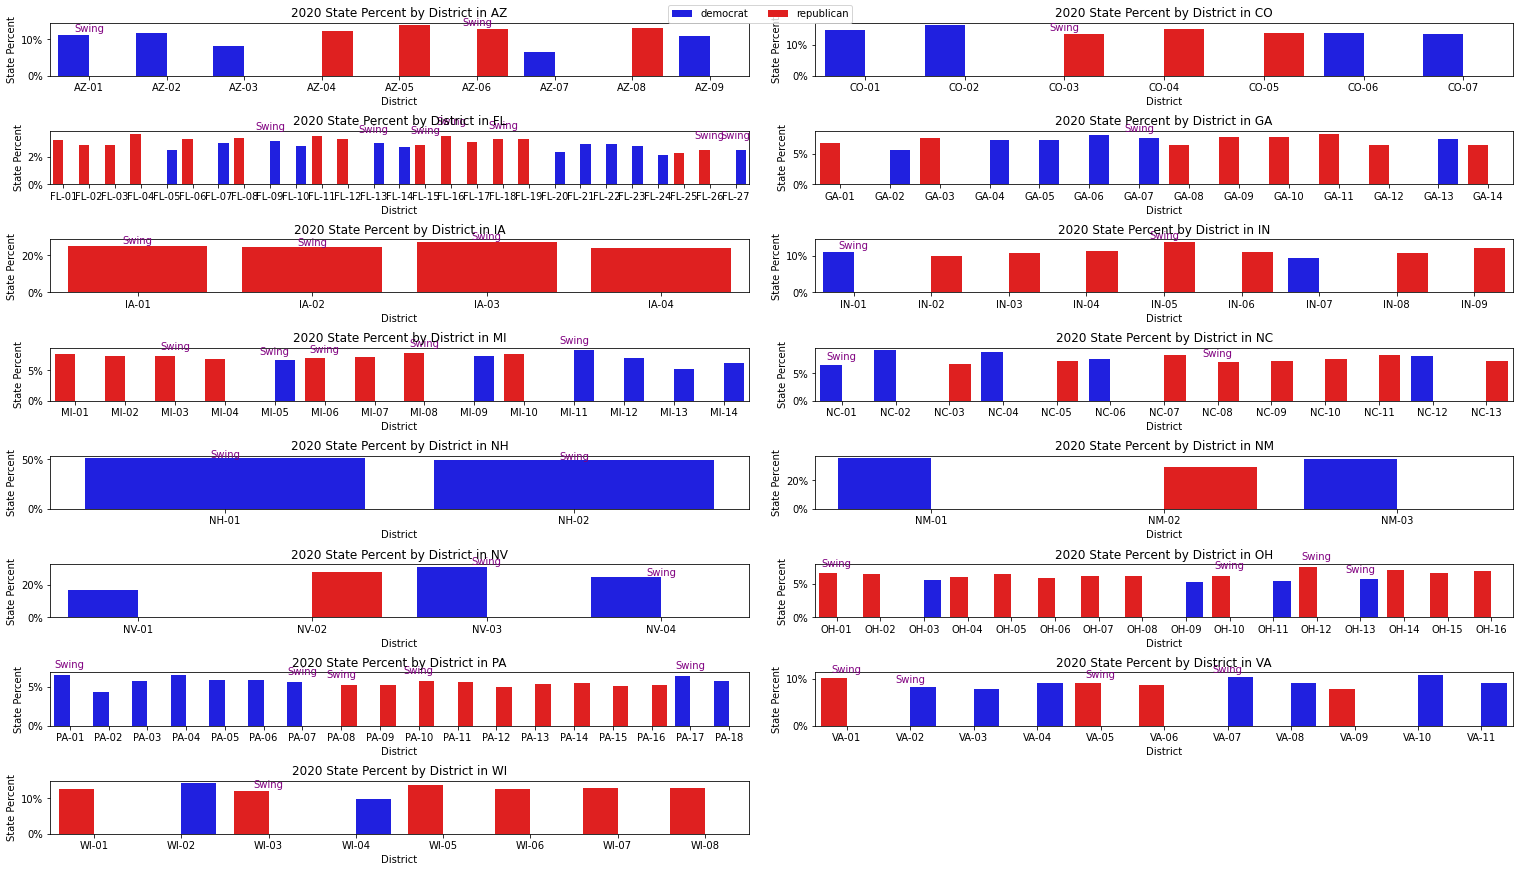

In [69]:
#filter DataFrame for the year 2020
df_2020 = modern_election_df[modern_election_df['Year'] == 2020]

#number of subplots
num_states = len(swing_states)
num_cols = 2  
num_rows = (num_states + num_cols - 1) // num_cols 

#create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(21, 12), constrained_layout=True)

#flatten axes array 
axes = axes.flatten()

#function to format y-axis as percentages
def to_percent(y, position):
    return f'{100 * y:.0f}%'


#iterate over swing states and plot
for idx, state in enumerate(swing_states):
    state_df = df_2020[df_2020['state'] == state]

    if not state_df.empty:
        sns.barplot(
            x='district', 
            y='state_percent', 
            hue='winner', 
            data=state_df,
            dodge=True,
            palette={'democrat': 'blue', 'republican': 'red'},
            ax=axes[idx]
        )

        #adding markers to indicate swing_district
        for i in range(len(state_df)):
            district = state_df.iloc[i]['district']
            state_percent = state_df.iloc[i]['state_percent']
            swing_district = state_df.iloc[i]['swing_district']

            color = 'purple' if swing_district == 'yes' else 'black'
            axes[idx].text(
                i, 
                state_percent + 0.01, 
                'Swing' if swing_district == 'yes' else '',
                color=color,
                ha="center"
            )

        axes[idx].set_title(f"2020 State Percent by District in {state}")
        axes[idx].set_xlabel("District")
        axes[idx].set_ylabel("State Percent")
        axes[idx].yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))

#remove legends from individual subplots
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes:
    legend = ax.get_legend()
    if legend:
        legend.remove()

#add a single legend to the top of the figure
fig.legend(handles, labels, loc='upper center', ncol=len(labels))

#remove empty subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

#display results
plt.show()

## Processing
In this section, we proceed to create a model to predict the winning party by congressional district.

### Train Test Split
We set up our data for a train_test_split.

In [70]:
#assign X and y from political_df columns
X = political_df.drop(['winner', 'Year', 'district', 'd_percent', 'r_percent', 'swing_district'], axis=1)
y = political_df['winner']

### Standard Scaler
We scaled the data for modeling.

In [71]:
#create an instance of the StandardScaler
scaler = StandardScaler()

#scale the numerical features
X_scaled = scaler.fit_transform(X)

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

### Model
We used logistic regression for our binary model, and increased the number of iterations.

In [72]:
#instantiate LogisticRegression
model = LogisticRegression(max_iter=500)

#fit the model onto the data
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [73]:
#assign predictions
y_pred = model.predict(X_test)

#assign accuracy score
accuracy = accuracy_score(y_test, y_pred)

#print results
print("Accuracy:", accuracy)

Accuracy: 0.9689922480620154


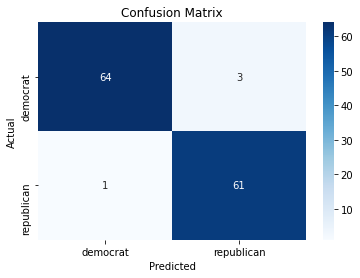

In [74]:
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#create a figure and axes
fig, ax = plt.subplots()

#create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

#set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['democrat', 'republican'])
ax.yaxis.set_ticklabels(['democrat', 'republican'])

#show the plot
plt.show()

### Accuracy Scores
We checked the training and testing accuracy to see if there were any issues with overfitting, and at first it seemed okay.

In [75]:
#find the train prediction
y_train_pred = model.predict(X_train)


#performance metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

#print results to check for fitting
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9966555183946488
Test Accuracy: 0.9689922480620154


### Cross-Validation
We ran a cross-validation with 5 folds to further assess the performance of the model. The results were quite good. 

In [76]:
#create a StratifiedKFold object
strat_k_fold = StratifiedKFold(n_splits=5)

#5-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=strat_k_fold)  

#display results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Cross-Validation Scores: [0.98333333 0.95       0.95       0.96666667 0.96610169]
Mean Cross-Validation Score: 0.9632203389830508


### Metrics

We took a look at the Recall, Precision, and F1 scores for the training and test data, and were pleased with the results.

In [77]:
#Training metrics
train_precision = precision_score(y_train, y_train_pred, pos_label='republican')
train_recall = recall_score(y_train, y_train_pred, pos_label='republican')
train_f1 = f1_score(y_train, y_train_pred, pos_label='republican')

#Test metrics
test_precision = precision_score(y_test, y_pred, pos_label='republican')
test_recall = recall_score(y_test, y_pred, pos_label='republican')
test_f1 = f1_score(y_test, y_pred, pos_label='republican')

#display results for training metrics
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1-Score:", train_f1)

#display results for test metrics
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

Training Precision: 0.993103448275862
Training Recall: 1.0
Training F1-Score: 0.9965397923875432
Test Precision: 0.953125
Test Recall: 0.9838709677419355
Test F1-Score: 0.9682539682539683


### Learning Curve
We plotted a learning curve. Given the constant perfect score of the training set, there's likely some overfitting happening. We will proceed with regularization techniques. 

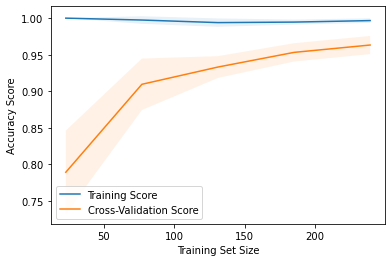

In [78]:
#create a learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=strat_k_fold)

#calculate mean and standard deviation
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

#plot learning curves
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

### Validation 
We analyzed the cross-validation score with different values for C, and liked the results.

In [79]:
#cross-validation scores for values of C
for c in [0.01, 0.1, 1, 10, 100]:
    model = LogisticRegression(C=c, solver='liblinear')
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"C={c}, Mean Cross-Validation Score: {scores.mean():.3f}")

C=0.01, Mean Cross-Validation Score: 0.896
C=0.1, Mean Cross-Validation Score: 0.946
C=1, Mean Cross-Validation Score: 0.963
C=10, Mean Cross-Validation Score: 0.963
C=100, Mean Cross-Validation Score: 0.957


We plotted a validation curve for different values of C and found "1" to be the optimal value.

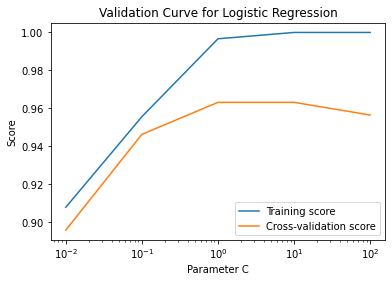

In [80]:
#set values for C
param_range = [0.01, 0.1, 1, 10, 100]

#set a validation curve
train_scores, test_scores = validation_curve(
    LogisticRegression(solver='liblinear'), X_train, y_train, param_name="C", param_range=param_range, cv=5
)

#calculate the means
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

#plot the values
plt.plot(param_range, train_scores_mean, label='Training score')
plt.plot(param_range, test_scores_mean, label='Cross-validation score')
plt.xlabel('Parameter C')
plt.ylabel('Score')
plt.legend()
plt.xscale('log')
plt.title('Validation Curve for Logistic Regression')
plt.show()

In [81]:
#display the optimal value for C
best_index = np.argmax(test_scores_mean)
best_C = param_range[best_index]
print(f"Optimal C: {best_C}")

Optimal C: 1


In [82]:
#calculate the test score for the optimal C value
optimal_model = LogisticRegression(C=best_C, solver='liblinear') 
optimal_model.fit(X_train, y_train) 
test_score = optimal_model.score(X_test, y_test) 
print(f"Test Score with Optimal C: {test_score:.3f}")

Test Score with Optimal C: 0.969


### Classification Report 
We checked the metrics of precision, recall, and F1, finding really high scores.

In [83]:
#print the metrics
y_pred = optimal_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[64  3]
 [ 1 61]]
              precision    recall  f1-score   support

    democrat       0.98      0.96      0.97        67
  republican       0.95      0.98      0.97        62

    accuracy                           0.97       129
   macro avg       0.97      0.97      0.97       129
weighted avg       0.97      0.97      0.97       129



### ROC Curve
We plotted an ROC Curve and found the area under the curve to be 100%. 

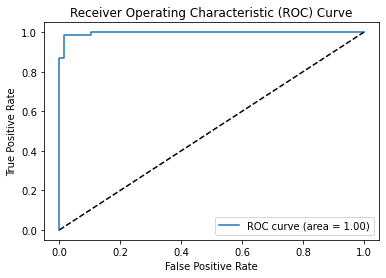

In [84]:
#converting the target values to numeric
y_test_numeric = y_test.map({'democrat': 0, 'republican': 1})

#calculate the roc metrics
y_pred_prob = optimal_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_prob)
roc_auc = roc_auc_score(y_test_numeric, y_pred_prob)

#plot the results
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Feature Importance
We took a look at the feature importance, finding significant data leakage. The two columns, republican total votes and democrat total votes, would obviously indicate a winner in a lopsided manner, so we proceeded to remove them and run through the model and evaluation again.

In [85]:
#calculate the feature importance
feature_importance = pd.Series(optimal_model.coef_[0], index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)

#display results
print(feature_importance)

r_total_votes                                                                         3.441405
total_votes                                                                           0.363048
$20000_to_24999                                                                       0.291727
Female_Construction                                                                   0.291666
Female_Public_administration                                                          0.243988
Female_Transportation_warehousing_utilities                                           0.241688
Total_Public_administration                                                           0.238014
Male_Finance_insurance_realestate_rental_leasing                                      0.227887
Male_Public_administration                                                            0.221694
Male_Agriculture_forestry_fishing_hunting_mining                                      0.197929
Male_Arts_entertainment_recreation_accommodation_f

In [86]:
#assign X and y from political_df columns
X = political_df.drop(['winner', 'Year', 'district', 'd_percent', 'r_percent', 
                       'r_total_votes', 'd_total_votes', 'swing_district'], axis=1)
y = political_df['winner']

In [87]:
#create an instance of the StandardScaler
scaler = StandardScaler()

#scale the numerical features
X_scaled = scaler.fit_transform(X)

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [88]:
#instantiate LogisticRegression
model = LogisticRegression(max_iter=500)

#fit the model onto the data
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

### Revised Model Evaluation Results
We found our scores to have dipped a bit, but are still in a solid place and the feature importance shows us that there is no longer significant leakage happening.

In [89]:
#assign predictions
y_pred = model.predict(X_test)

#assign accuracy score
accuracy = accuracy_score(y_test, y_pred)

#print results
print("Accuracy:", accuracy)

Accuracy: 0.8682170542635659


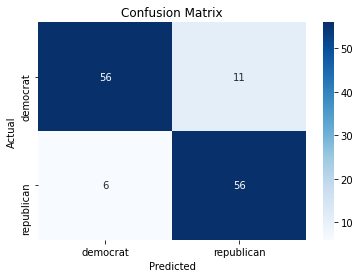

In [90]:
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#create a figure and axes
fig, ax = plt.subplots()

#create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

#set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['democrat', 'republican'])
ax.yaxis.set_ticklabels(['democrat', 'republican'])

#show the plot
plt.show()

In [91]:
#find the train prediction
y_train_pred = model.predict(X_train)


#performance metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

#print results to check for fitting
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.8361204013377926
Test Accuracy: 0.8682170542635659


In [92]:
#create a StratifiedKFold object
strat_k_fold = StratifiedKFold(n_splits=5)

#5-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=strat_k_fold)  

#display results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Cross-Validation Scores: [0.75       0.83333333 0.76666667 0.78333333 0.71186441]
Mean Cross-Validation Score: 0.7690395480225989


Our scores have dipped a bit, but we no longer have that data leakage.

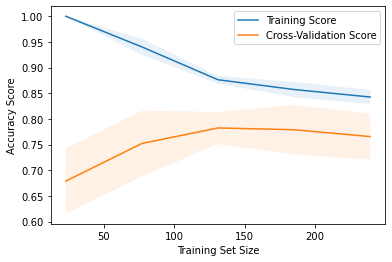

In [93]:
#create a learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=strat_k_fold)

#calculate mean and standard deviation
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

#plot learning curves
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

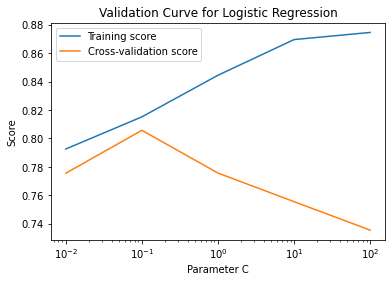

In [94]:
#set values for C
param_range = [0.01, 0.1, 1, 10, 100]

#calculate validation curve
train_scores, test_scores = validation_curve(
    LogisticRegression(solver='liblinear'), X_train, y_train, param_name="C", param_range=param_range, cv=5
)

#calculate means
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

#plot results
plt.plot(param_range, train_scores_mean, label='Training score')
plt.plot(param_range, test_scores_mean, label='Cross-validation score')
plt.xlabel('Parameter C')
plt.ylabel('Score')
plt.legend()
plt.xscale('log')
plt.title('Validation Curve for Logistic Regression')
plt.show()

In [95]:
#display optimal C
best_index = np.argmax(test_scores_mean)
best_C = param_range[best_index]
print(f"Optimal C: {best_C}")

Optimal C: 0.1


In [96]:
#calculate test score for optimal C
optimal_model = LogisticRegression(C=best_C, solver='liblinear', random_state=42) 
optimal_model.fit(X_train, y_train) 
test_score = optimal_model.score(X_test, y_test) 
print(f"Test Score with Optimal C: {test_score:.3f}")

Test Score with Optimal C: 0.884


In [97]:
#classification report
y_pred = optimal_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[58  9]
 [ 6 56]]
              precision    recall  f1-score   support

    democrat       0.91      0.87      0.89        67
  republican       0.86      0.90      0.88        62

    accuracy                           0.88       129
   macro avg       0.88      0.88      0.88       129
weighted avg       0.88      0.88      0.88       129



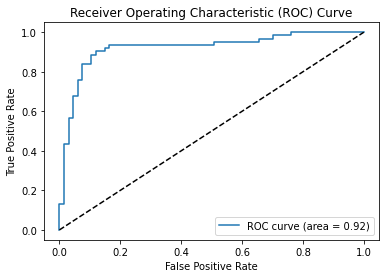

In [98]:
#converting the target values to numeric
y_test_numeric = y_test.map({'democrat': 0, 'republican': 1})

#calculate roc
y_pred_prob = optimal_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_numeric, y_pred_prob)
roc_auc = roc_auc_score(y_test_numeric, y_pred_prob)

#plot results
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [99]:
#calculate and display feature importance
feature_importance = pd.Series(optimal_model.coef_[0], index=X.columns)
feature_importance.sort_values(ascending=False, inplace=True)
print(feature_importance)

total_votes                                                                           0.390138
Male_Agriculture_forestry_fishing_hunting_mining                                      0.321300
Female_Construction                                                                   0.309341
$20000_to_24999                                                                       0.291319
Total_Agriculture_forestry_fishing_hunting_mining                                     0.260717
Male_Public_administration                                                            0.217116
$25000_to_34999                                                                       0.216783
Male_Manufacturing                                                                    0.215440
$15000_to_19999                                                                       0.189038
Female_Retail_trade                                                                   0.185021
$50000_to_74999                                   

In [100]:
#training metrics
train_precision = precision_score(y_train, y_train_pred, pos_label='republican')
train_recall = recall_score(y_train, y_train_pred, pos_label='republican')
train_f1 = f1_score(y_train, y_train_pred, pos_label='republican')

#test metrics
test_precision = precision_score(y_test, y_pred, pos_label='republican')
test_recall = recall_score(y_test, y_pred, pos_label='republican')
test_f1 = f1_score(y_test, y_pred, pos_label='republican')

#display results for training metrics
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1-Score:", train_f1)

#display results for test metrics
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-Score:", test_f1)

Training Precision: 0.8104575163398693
Training Recall: 0.8611111111111112
Training F1-Score: 0.8350168350168351
Test Precision: 0.8615384615384616
Test Recall: 0.9032258064516129
Test F1-Score: 0.8818897637795274


### Regularization
We added L2 regularization for Ridge Regression, then ran the model with our optimal C value of 0.1.

In [101]:
#create a model with ridge regression
ridge_model = LogisticRegression(C=best_C, solver='liblinear', penalty='l2', random_state=42)
ridge_model.fit(X_train, y_train)

LogisticRegression(C=0.1, random_state=42, solver='liblinear')

### Model Comparison
We plotted several baseline models to compare the learning curve, finding logistic regression to be the best fit.

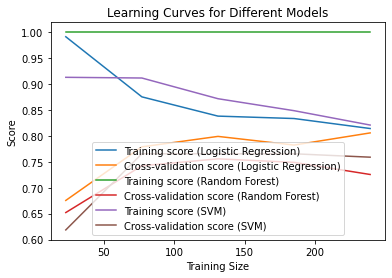

In [102]:
#list several models to compare 
models = [
       ('Logistic Regression', LogisticRegression(C=best_C, solver='liblinear')),
       ('Random Forest', RandomForestClassifier()),
       ('SVM', SVC(probability=True))
   ]

#calculate learning curve, mean scores for each model
for name, model in models:
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label=f'Training score ({name})')
    plt.plot(train_sizes, test_scores_mean, label=f'Cross-validation score ({name})')

#plot results
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.title('Learning Curves for Different Models')
plt.show()

#### Normalized Data Model Comparison
Next we tried fitting a Random Forest Classifier onto the normalized data and checked the results.

In [103]:
#set the 'winner' column in normal_df
for index, row in normal_df.iterrows():
    if row['d_percent'] > row['r_percent']:
        normal_df.at[index, 'winner'] = 'democrat'
    elif row['r_percent'] > row['d_percent']:
        normal_df.at[index, 'winner'] = 'republican'
    else:
        normal_df.at[index, 'winner'] = 'neither'

In [104]:
#assign X and y from political_df columns
X_normal = normal_df.drop(['winner', 'Year', 'district', 'd_percent', 'r_percent'], axis=1)
y_normal = normal_df['winner']

In [105]:
#train_test_split
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(X_normal, y_normal, test_size=0.3, random_state=42, stratify=y)

#instantiate RandomForestClassifier
normal_model = RandomForestClassifier(random_state=42)

#fit the model onto the data
normal_model.fit(X_train_normal, y_train_normal)

RandomForestClassifier(random_state=42)

In [106]:
#assign predictions
y_pred_normal = normal_model.predict(X_test_normal)

#assign accuracy score
accuracy_normal = accuracy_score(y_test_normal, y_pred_normal)

#print results
print("Accuracy:", accuracy_normal)

Accuracy: 0.8527131782945736


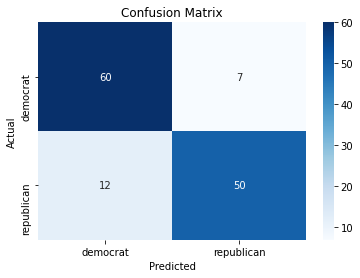

In [107]:
#calculate the confusion matrix
cm_normal = confusion_matrix(y_test_normal, y_pred_normal)

#create a figure and axes
fig, ax = plt.subplots()

#create a heatmap
sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', ax=ax)

#set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['democrat', 'republican'])
ax.yaxis.set_ticklabels(['democrat', 'republican'])

#show the plot
plt.show()

In [108]:
#find the train prediction
y_train_pred_normal = normal_model.predict(X_train_normal)


#performance metrics
train_accuracy_normal = accuracy_score(y_train_normal, y_train_pred_normal)
test_accuracy_normal = accuracy_score(y_test_normal, y_pred_normal)

#print results to check for fitting
print("Training Accuracy:", train_accuracy_normal)
print("Test Accuracy:", test_accuracy_normal)

Training Accuracy: 1.0
Test Accuracy: 0.8527131782945736


In [109]:
#5-fold cross-validation
cv_scores_normal = cross_val_score(normal_model, X_train_normal, y_train_normal, cv=strat_k_fold)  

#display results
print("Cross-Validation Scores:", cv_scores_normal)
print("Mean Cross-Validation Score:", cv_scores_normal.mean())

Cross-Validation Scores: [0.75       0.8        0.81666667 0.68333333 0.69491525]
Mean Cross-Validation Score: 0.7489830508474575


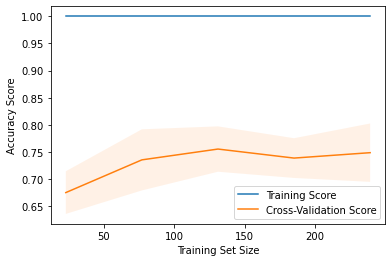

In [110]:
#create a learning curve
train_sizes_normal, train_scores_normal, test_scores_normal = learning_curve(normal_model, X_train_normal, y_train_normal, cv=strat_k_fold)

#calculate mean and standard deviation
train_mean_normal = train_scores_normal.mean(axis=1)
train_std_normal = train_scores_normal.std(axis=1)
test_mean_normal = test_scores_normal.mean(axis=1)
test_std_normal = test_scores_normal.std(axis=1)

#plot learning curves
plt.plot(train_sizes_normal, train_mean_normal, label="Training Score")
plt.plot(train_sizes_normal, test_mean_normal, label="Cross-Validation Score")
plt.fill_between(train_sizes_normal, train_mean_normal - train_std_normal, train_mean_normal + train_std_normal, alpha=0.1)
plt.fill_between(train_sizes_normal, test_mean_normal - test_std_normal, test_mean_normal + test_std_normal, alpha=0.1)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.show()

In [111]:
#classification report
y_pred_normal = normal_model.predict(X_test_normal)
print(classification_report(y_test_normal, y_pred_normal))

              precision    recall  f1-score   support

    democrat       0.83      0.90      0.86        67
  republican       0.88      0.81      0.84        62

    accuracy                           0.85       129
   macro avg       0.86      0.85      0.85       129
weighted avg       0.85      0.85      0.85       129



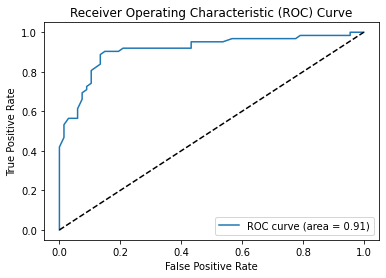

In [112]:
#calculate roc
y_pred_prob_normal = normal_model.predict_proba(X_test_normal)[:, 1]
fpr_normal, tpr_normal, thresholds_normal = roc_curve(y_test_numeric, y_pred_prob_normal)
roc_auc_normal = roc_auc_score(y_test_numeric, y_pred_prob_normal)

#plot results
plt.plot(fpr_normal, tpr_normal, label=f"ROC curve (area = {roc_auc_normal:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Hyperparameter Tuning
We ran hyperparameter tuning on our two models, then compared them and made a final evaluation.

In [113]:
#define the parameter grid
param_grid_forest = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

#initialize GridSearchCV
grid_search_normal = GridSearchCV(estimator=normal_model, param_grid=param_grid_forest, cv=5)

#fit the model
grid_search_normal.fit(X_train_normal, y_train_normal)

# Get the best parameters
best_params_normal = grid_search_normal.best_params_
print(best_params_normal)

{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


In [114]:
#create a pipeline to scale the data and then apply logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l2', max_iter=1000))
])

#define the parameter grid 
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10],
    'logreg__solver': ['liblinear', 'lbfgs']
}

#initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)

#fit the model
grid_search.fit(X_train, y_train)

#get the best parameters
best_params = grid_search.best_params_
print(best_params)

{'logreg__C': 0.1, 'logreg__solver': 'liblinear'}


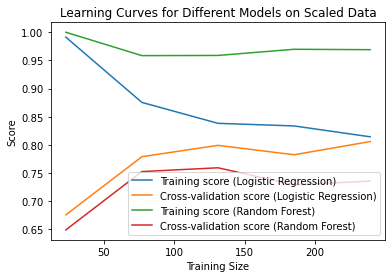

In [115]:
#list several models to compare 
models = [
       ('Logistic Regression', LogisticRegression(C=0.1, solver='liblinear')),
       ('Random Forest', RandomForestClassifier(max_depth=None, min_samples_split=10, n_estimators=100)),
   ]

#calculate learning curve, mean scores for each model
for name, model in models:
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label=f'Training score ({name})')
    plt.plot(train_sizes, test_scores_mean, label=f'Cross-validation score ({name})')

#plot results
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.title('Learning Curves for Different Models on Scaled Data')
plt.show()

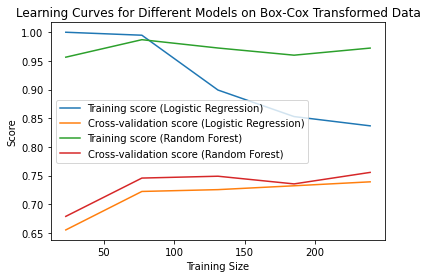

In [116]:
#list several models to compare 
models = [
       ('Logistic Regression', LogisticRegression(C=0.1, solver='liblinear', max_iter=5000, random_state=42)),
       ('Random Forest', RandomForestClassifier(max_depth=None, min_samples_split=10, n_estimators=100, random_state=42)),
   ]

#calculate learning curve, mean scores for each model
for name, model in models:
    train_sizes, train_scores, test_scores = learning_curve(model, X_train_normal, y_train_normal, cv=5)

    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    plt.plot(train_sizes, train_scores_mean, label=f'Training score ({name})')
    plt.plot(train_sizes, test_scores_mean, label=f'Cross-validation score ({name})')

#plot results
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.title('Learning Curves for Different Models on Box-Cox Transformed Data')
plt.show()

### Final Selection
The decision was made to select our Logistic Regression model with the scaled data.

In [117]:
#assign X and y from political_df columns
X = political_df.drop(['winner', 'Year', 'district', 'd_percent', 'r_percent', 
                       'r_total_votes', 'd_total_votes', 'swing_district'], axis=1)
y = political_df['winner']

#create an instance of the StandardScaler
scaler = StandardScaler()

#scale the numerical features
X_scaled = scaler.fit_transform(X)

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

#instantiate LogisticRegression with tuning parameters
best_model = LogisticRegression(C=0.1, solver='liblinear', random_state=42)

#fit the model onto the data
best_model.fit(X_train, y_train)

#assign predictions
y_pred = best_model.predict(X_test)

#assign accuracy score
accuracy = accuracy_score(y_test, y_pred)

#print results
print("Accuracy:", accuracy)

Accuracy: 0.8837209302325582


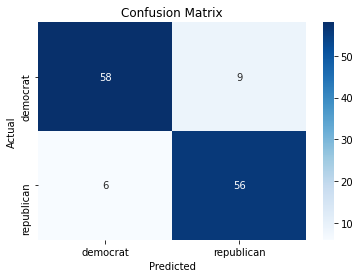

In [118]:
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#create a figure and axes
fig, ax = plt.subplots()

#create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

#set labels, title, and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['democrat', 'republican'])
ax.yaxis.set_ticklabels(['democrat', 'republican'])

#show the plot
plt.show()

In [119]:
#classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    democrat       0.91      0.87      0.89        67
  republican       0.86      0.90      0.88        62

    accuracy                           0.88       129
   macro avg       0.88      0.88      0.88       129
weighted avg       0.88      0.88      0.88       129



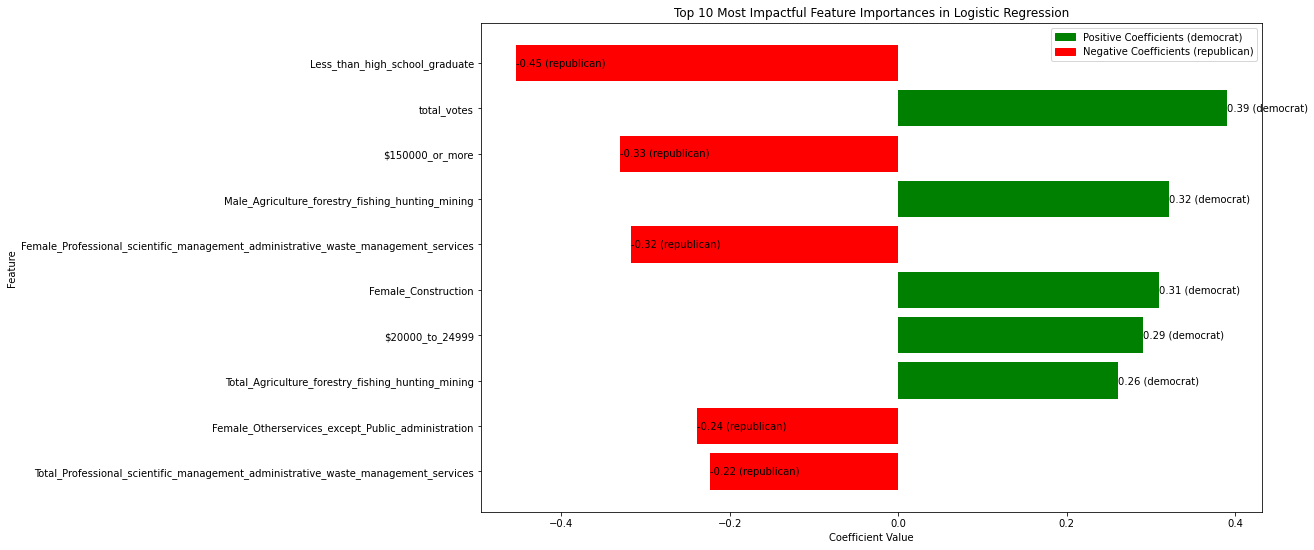

In [120]:
#extract coefficients
coefficients = best_model.coef_[0]

#convert numpy to dataframe
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=X.columns)

#extract feature importance
feature_importance = pd.Series(best_model.coef_[0], index=X_train.columns)

#select top N features
N = 10  
top_feature_importance = feature_importance.reindex(feature_importance.abs().sort_values(ascending=False).index).head(N)

# Reverse the values for plotting and color assignment
top_feature_importance_reversed = top_feature_importance.values[::-1]
top_feature_names_reversed = top_feature_importance.index[::-1]

#plot 
plt.figure(figsize=(14, 9))

#use different colors for positive and negative coefficients
colors = ['green' if coef > 0 else 'red' for coef in top_feature_importance_reversed]

#plot and labels
bars = plt.barh(range(N), top_feature_importance_reversed, align='center', color=colors)
plt.yticks(range(N), top_feature_importance.index[::-1])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top {N} Most Impactful Feature Importances in Logistic Regression')

#add coefficient values and direction annotations next to bars
for bar, coef in zip(bars, top_feature_importance_reversed):
    direction = 'democrat' if coef > 0 else 'republican'
    plt.gca().text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                   f'{bar.get_width():.2f} ({direction})', ha='left', va='center')

#create custom legend handles
legend_handles = [
    Patch(color='green', label='Positive Coefficients (democrat)'),
    Patch(color='red', label='Negative Coefficients (republican)')
]

#add a custom legend
plt.legend(handles=legend_handles, loc='best')


#display results
plt.show()

### Lollipop Chart

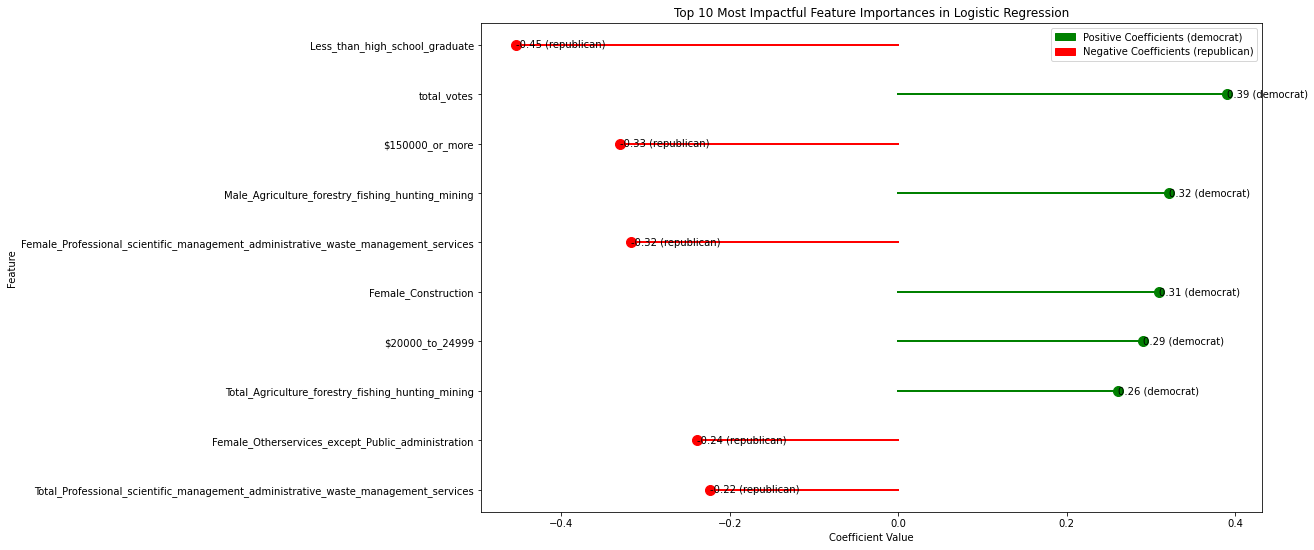

In [121]:
#plot the top N features as a lollipop chart
plt.figure(figsize=(14, 9))

#use different colors for positive and negative coefficients
colors = ['green' if coef > 0 else 'red' for coef in top_feature_importance_reversed]

#create the lollipop chart
for i, (feature, coef, color) in enumerate(zip(top_feature_names_reversed, top_feature_importance_reversed, colors)):
    plt.plot([0, coef], [i, i], color=color, linewidth=2)
    plt.scatter(coef, i, color=color, s=100, zorder=3)

#set labels
plt.yticks(range(N), top_feature_names_reversed)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title(f'Top {N} Most Impactful Feature Importances in Logistic Regression')

#add coefficient values and direction annotations next to points
for i, coef in enumerate(top_feature_importance_reversed):
    direction = 'democrat' if coef > 0 else 'republican'
    plt.gca().text(coef, i, f'{coef:.2f} ({direction})', ha='left', va='center')

#create custom legend handles
legend_handles = [
    Patch(color='green', label='Positive Coefficients (democrat)'),
    Patch(color='red', label='Negative Coefficients (republican)')
]

#add a custom legend
plt.legend(handles=legend_handles, loc='best')

#display results
plt.show()

### Heatmap

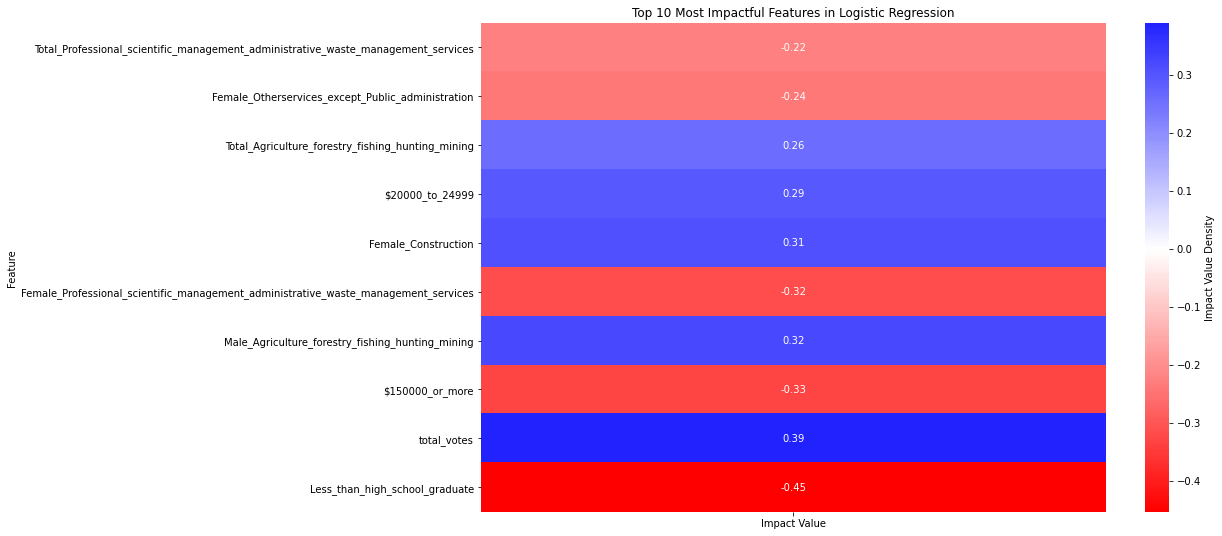

In [122]:
#plot the top N features as a heatmap
plt.figure(figsize=(14, 9))

#create a DataFrame for the heatmap
top_features_df = pd.DataFrame(top_feature_importance_reversed, index=top_feature_names_reversed, columns=['Impact Value'])

#create a custom colormap: green for positive, red for negative
custom_palette = LinearSegmentedColormap.from_list("custom", ["red", "white", "blue"])

#use seaborn to create the heatmap
heatmap = sns.heatmap(top_features_df, annot=True, cmap=custom_palette, center=0, cbar_kws={'label': 'Impact Value Density'})

#set labels
plt.title(f'Top {N} Most Impactful Features in Logistic Regression')
plt.ylabel('Feature')

#display results
plt.show()

## Conclusions

* 1. The higher the vote turnout, the likelier a Democrat victory.
* 2. The higher the percentage of voters without a high school diploma, the likelier a Republican victory.
* 3. The Democrats have performed better in the swing states in recent elections, but have lost Florida and Ohio. 

## Next Steps
* 1. Find more data to improve the model's performance.
* 2. Look into the Census data from election years prior to 2020 to further identify trends and more precisely target winnable districts.